# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('etau_tree', {'root_raw/et18_raw/ggH_bbtt*.root', 'root_raw/et18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('etau_tree', 'root_raw/et18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('etau_tree', {'root_raw/et17_raw/ggH_bbtt*.root', 'root_raw/et17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('etau_tree', 'root_raw/et17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('etau_tree', {'root_raw/et16_raw/ggH_bbtt*.root', 'root_raw/et16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('etau_tree', 'root_raw/et16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 2b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.2770').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.2770')
    files17[i] = files17[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3033').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3033')
    files16[i] = files16[i].Filter('bpt_deepflavour_1>20 && bscore_deepflavour_1>0.3093').Filter('bpt_deepflavour_2>20 && bscore_deepflavour_2>0.3093')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mytau = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mytau+mymet).Pt(),(myele+mytau+mymet).Eta(),(myele+mytau+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_1,beta_deepflavour_1,bphi_deepflavour_1,bm_deepflavour_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepflavour_2,beta_deepflavour_2,bphi_deepflavour_2,bm_deepflavour_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1ele = '(myele+myb1).M()'
m_b1tau = '(mytau+myb1).M()'
m_b2ele = '(myele+myb2).M()'
m_b2tau = '(mytau+myb2).M()'
m_bbele = '(myb1+myb2+myele).M()'
m_bbtau = '(myb1+myb2+mytau).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mytau)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb1)'
dR_b2ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb2)'
dR_b2tau = 'ROOT::Math::VectorUtil::DeltaR(mytau,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbele = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,myele)'
dR_bbtau = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mytau)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'

tt_pt = 'mytt.Pt()'
tt_eta = 'mytt.Eta()'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_tau = 'sqrt(pow(mytau.Pt()+mymet.Pt(),2)-pow(mytau.Px()+mymet.Px(),2)-pow(mytau.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt(),2)+pow(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mytau.Px()/mytau.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mytau.Py()/mytau.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mytau.Px())*x_zeta+(myele.Py()+mytau.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)\
    .Define('tt_pt', tt_pt)\
    .Define('tt_eta', tt_eta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+tau trigger requirements
trigger32_18 = '(passEle32 && pt_1>33 && matchEle32_1 && filterEle32_1)'
trigger35_18 = '(passEle35 && pt_1>33 && matchEle35_1 && filterEle35_1)'
trigger2430_18 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_18 = '(passEle24HPSTau30 && matchEle24HPSTau30_1 && filterEle24HPSTau30_1 && matchEle24HPSTau30_2 && filterEle24HPSTau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'
trigger2430HPS_emb_18 = '(matchEmbFilter_Ele24Tau30_1 && matchEmbFilter_Ele24Tau30_2 && pt_1>25 && pt_2>35 && fabs(eta_2)<2.1 && pt_1<=33)'

trigger_mc_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_1_18 = trigger2430_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_obs_2_18 = trigger2430HPS_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18
trigger_emb_18 = trigger2430HPS_emb_18 + str(' or ') + trigger32_18 + str(' or ') + trigger35_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files18[2] = files18[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
obs1_18 = files18[0].Filter('run<317509').Filter(trigger_obs_1_18)
obs2_18 = files18[0].Filter('run>=317509').Filter(trigger_obs_2_18)
files18[1] = files18[1].Filter(trigger_mc_18)
files18[2] = files18[2].Filter(trigger_emb_18)
files18[3] = files18[3].Filter(trigger_mc_18)

# QCD region
qcd1_18 = obs1_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')
qcd2_18 = obs2_18.Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 7 ##########################
# 2017 mu+tau trigger requirements
trigger32_17 = '(passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_17 = '(passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_17 = '(passEle24Tau30 && matchEle24Tau30_1 && filterEle24Tau30_1 && matchEle24Tau30_2 && filterEle24Tau30_2 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
# requirements on embedded
trigger32_emb1_17 = '(fabs(eta_1)<1.479 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1)'
trigger27_emb1_17 = '(fabs(eta_1)<1.479 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)'
trigger2430_emb1_17 = '(fabs(eta_1)<1.479 && passEle24Tau30 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'
triggersingle_emb2_17 = '(fabs(eta_1)>1.479 && ((pt_1>28 && pt_1<40) or (pt_1>40 && passEle32 && pt_1>28 && matchEle32_1 && filterEle32_1) or (pt_1>40 && passEle27 && pt_1>28 && matchEle27_1 && filterEle27_1)))'
triggercross_emb2_17 = '(fabs(eta_1)>1.479 && pt_1>25 && pt_2>35 && pt_1<28 && fabs(eta_2)<2.1)'

trigger_mc_obs_17 = trigger2430_17 + str(' or ') + trigger32_17 + str(' or ') + trigger27_17
trigger_emb_17 = trigger32_emb1_17 + str(' or ') + trigger27_emb1_17 + str(' or ') + trigger2430_emb1_17 + str(' or ') + triggersingle_emb2_17 + str(' or ') + triggercross_emb2_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files17[2] = files17[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files17[0] = files17[0].Filter(trigger_mc_obs_17)
files17[1] = files17[1].Filter(trigger_mc_obs_17)
files17[2] = files17[2].Filter(trigger_emb_17)
files17[3] = files17[3].Filter(trigger_mc_obs_17)

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

######################## 2 0 1 6 ##########################
# 2016 mu+tau trigger requirements
trigger25_16 = '(passEle25 && matchEle25_1 && filterEle25_1 && pt_1>26)'

trigger_all_16 = trigger25_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('pt_2>20')\
    .Filter('fabs(eta_1)<2.1 && fabs(eta_2)<2.3')\
    .Filter('iso_1<0.15')\
    .Filter('byVLooseDeepVSmu_2 && byTightDeepVSe_2')\
    .Filter('dR_tt>0.4')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('gen_match_2!=6').Filter('(gen_match_1<3 or gen_match_1==6) or (gen_match_1==3 && gen_match_2<3)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==5')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_b1tt<200').Filter('dm_a<2').Filter('m_bbtt<400')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('gen_match_2!=6').Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16)
files16[1] = files16[1].Filter(trigger_all_16)
files16[2] = files16[2].Filter(trigger_all_16)
files16[3] = files16[3].Filter(trigger_all_16)

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('byMediumDeepVSjet_2==0')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')\
    .Filter('byMediumDeepVSjet_2')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1ele', 'm_b1tau', 'm_b2ele', 'm_b2tau', 'dm_a',\
                'm_bbele', 'm_bbtau', 'dR_tt', 'dR_b1ele', 'dR_b1tau', 'dR_b2ele', 'dR_b2tau', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbele','dR_bbtau', 'mT_ele', 'mT_tau', 'mT_b1', 'mT_b2', 'Dzeta',\
                'bpt_deepflavour_1', 'bpt_deepflavour_2', 'tt_pt', 'tt_eta']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd1_18 = pd.DataFrame(qcd1_18.AsNumpy(feature_list))
qcd2_18 = pd.DataFrame(qcd2_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18_1.shape: ' + str(qcd1_18.shape))
print('qcd18_2.shape: ' + str(qcd2_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd1_18, qcd2_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (1224, 30)
ZTT18.shape  : (11162, 30)
TT18.shape   : (276178, 30)
qcd18_1.shape: (9293, 30)
qcd18_2.shape: (19987, 30)

sig17.shape  : (1732, 30)
ZTT17.shape  : (11082, 30)
TT17.shape   : (41922, 30)
qcd17.shape  : (18709, 30)

sig16.shape  : (1620, 30)
ZTT16.shape  : (5388, 30)
TT16.shape   : (25657, 30)
qcd16.shape  : (15143, 30)

sig_allyears.shape: (4576, 31)
ZTT_allyears.shape: (27632, 31)
TT_allyears.shape : (343757, 31)
qcd_allyears.shape: (63132, 31)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 220, random_state = 20)#1174->4.8%->269
TT_allyears = TT_allyears.sample(n = 3340, random_state = 20)#17807->73%->4092
qcd_allyears = qcd_allyears.sample(n = 1016, random_state = 20)#5427->22.2%->1244

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1      m_b1tt      m_b2tt      m_bbtt        m_bb     m_b1ele  \
0      35.527386   81.428417   90.568541  121.758682   25.198803   65.194203   
1      39.419514   68.185363  105.386576  125.656761   26.219307   42.050382   
2      35.017666  103.673462   86.115231  140.385348   48.015865   67.815173   
3      45.480015   71.642926  184.829852  203.912696   53.253670   63.885082   
4      45.410255   68.906812   91.728588  114.175839   23.557440   47.314974   
...          ...         ...         ...         ...         ...         ...   
5662   56.888676  256.049283  227.894761  293.765402   83.872954   72.512382   
6622   96.230789  351.425238  423.541483  484.672856  149.268321  136.920878   
3416   57.669075  212.067333  142.101225  274.163163  144.788347  111.882091   
17528  82.987183  305.150312  310.036973  340.764017   52.411059   49.512424   
5869   44.783924  108.591181  125.353627  152.026739   35.401657   69.888252   

          m_b1tau     m

## Compare input feature distributions between sig and bkg

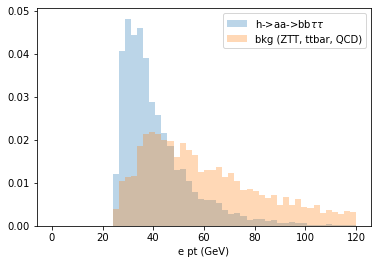

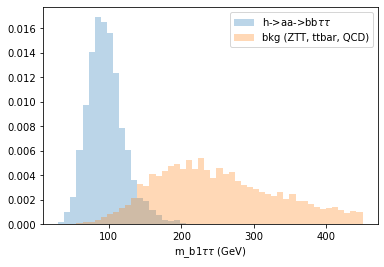

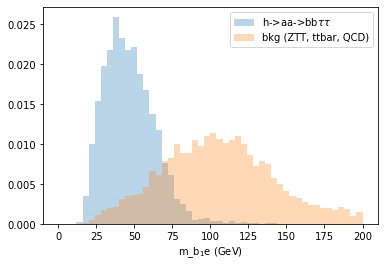

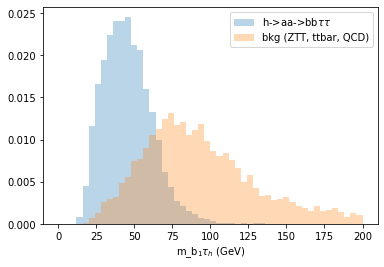

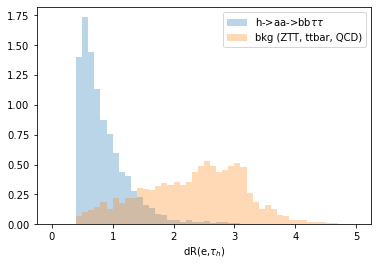

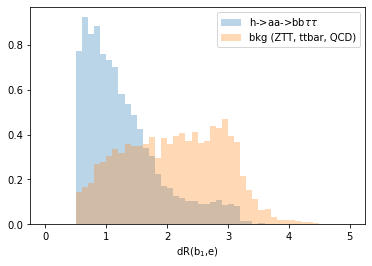

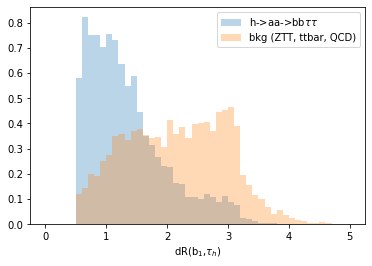

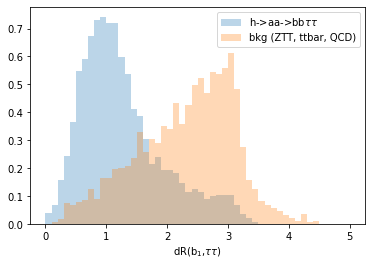

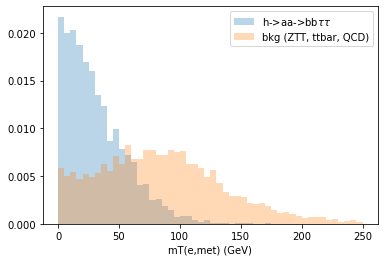

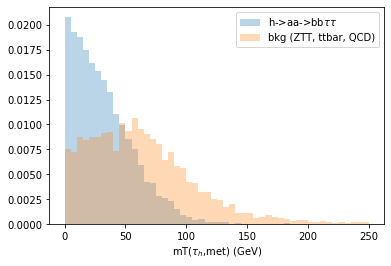

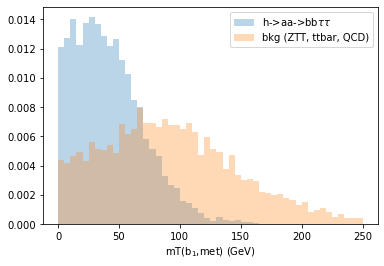

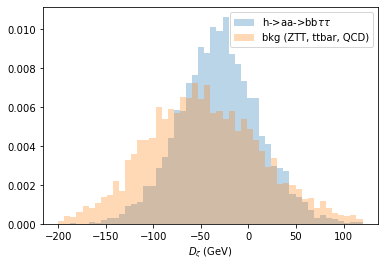

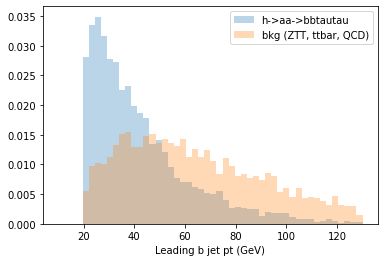

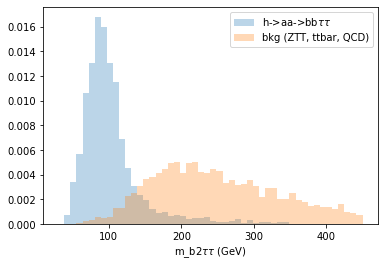

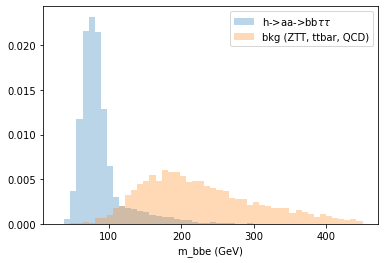

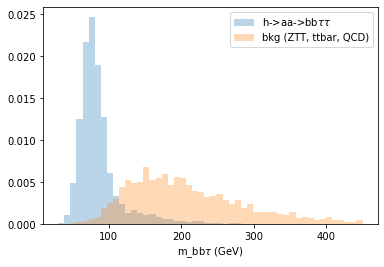

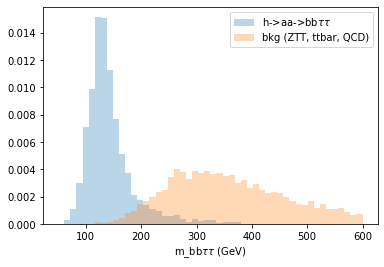

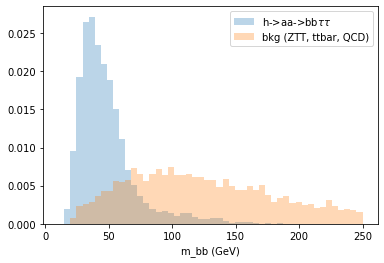

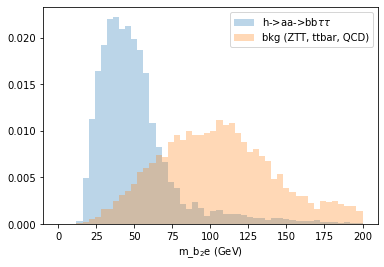

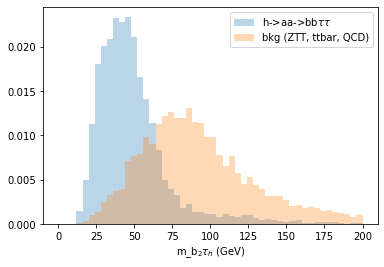

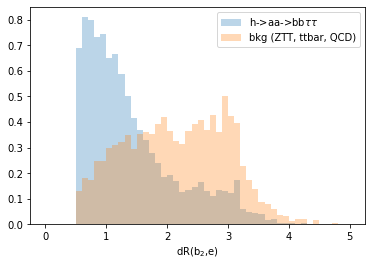

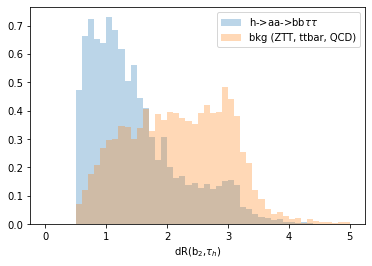

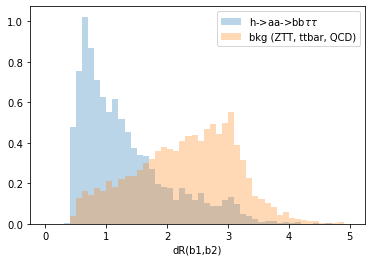

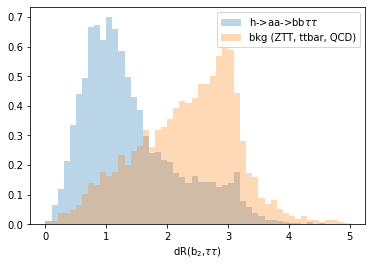

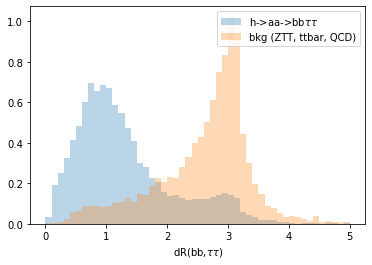

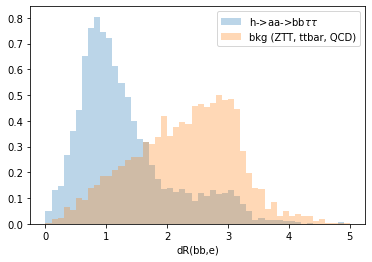

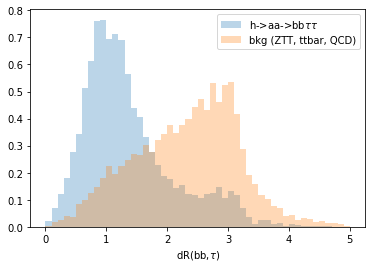

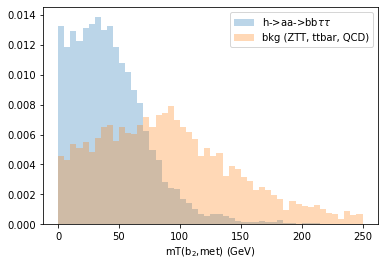

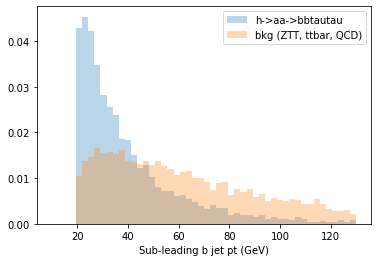

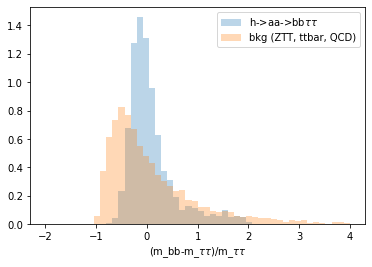

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1tau'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tau'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_tau'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\\tau_h$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepflavour_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

############## for 2b events
pyplot.hist(sig_allyears['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbele'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbele'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bbe (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtau'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tau'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\\tau_h$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau_h$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbtau'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepflavour_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()




pyplot.hist(sig_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_pt'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['tt_eta'], density = 1, range = (-2.4,2.4), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\\tau\\tau$ $\eta$')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.50/0.25/0.25
X_train.shape: (4576, 30)
Y_train.shape: (4576, 1)
X_val.shape: (2288, 30)
Y_val.shape: (2288, 1)
X_test.shape: (2288, 30)
Y_test.shape: (2288, 1)

Total number of sig/bkg examples: 4576/4576 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 2269/2307 (49.6%/50.4%)
val   : 1130/1158 (49.4%/50.6%)
test  : 1177/1111 (51.4%/48.6%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-04-12 14:46:21.318781: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-12 14:46:21.319196: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 128)

Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 23s - loss: 0.7727 - accuracy: 0.414 - ETA: 1s - loss: 0.6114 - accuracy: 0.690 - ETA: 0s - loss: 0.5216 - accuracy: 0.78 - ETA: 0s - loss: 0.4473 - accuracy: 0.82 - 1s 237us/sample - loss: 0.4014 - accuracy: 0.8505 - val_loss: 0.1890 - val_accuracy: 0.9401
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.93 - ETA: 0s - loss: 0.2064 - accuracy: 0.92 - ETA: 0s - loss: 0.1803 - accuracy: 0.93 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1634 - accuracy: 0.9458 - val_loss: 0.1170 - val_accuracy: 0.9602
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0798 - accuracy: 0.98 - ETA: 0s - loss: 0.1183 - accuracy: 0.95 - ETA: 0s - loss: 0.1217 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1090 - accuracy: 0.9600 - val_loss: 0.0937 - val_accuracy: 0.9646


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 18s - loss: 0.7966 - accuracy: 0.453 - ETA: 1s - loss: 0.7136 - accuracy: 0.564 - ETA: 0s - loss: 0.6252 - accuracy: 0.64 - ETA: 0s - loss: 0.5543 - accuracy: 0.70 - 1s 196us/sample - loss: 0.5182 - accuracy: 0.7308 - val_loss: 0.2435 - val_accuracy: 0.9349
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.90 - ETA: 0s - loss: 0.3041 - accuracy: 0.88 - ETA: 0s - loss: 0.2725 - accuracy: 0.89 - ETA: 0s - loss: 0.2548 - accuracy: 0.90 - 0s 60us/sample - loss: 0.2473 - accuracy: 0.9095 - val_loss: 0.1489 - val_accuracy: 0.9484
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.94 - ETA: 0s - loss: 0.1894 - accuracy: 0.93 - ETA: 0s - loss: 0.1820 - accuracy: 0.93 - ETA: 0s - loss: 0.1855 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1802 - accuracy: 0.9382 - val_loss: 0.1176 - val_accuracy: 0.9594


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7263 - accuracy: 0.468 - ETA: 1s - loss: 0.5693 - accuracy: 0.661 - ETA: 0s - loss: 0.4903 - accuracy: 0.76 - ETA: 0s - loss: 0.4381 - accuracy: 0.80 - 1s 195us/sample - loss: 0.4087 - accuracy: 0.8260 - val_loss: 0.1843 - val_accuracy: 0.9532
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.92 - ETA: 0s - loss: 0.1835 - accuracy: 0.95 - ETA: 0s - loss: 0.1886 - accuracy: 0.94 - ETA: 0s - loss: 0.1760 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1665 - accuracy: 0.9489 - val_loss: 0.1047 - val_accuracy: 0.9642
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1416 - accuracy: 0.96 - ETA: 0s - loss: 0.1163 - accuracy: 0.96 - ETA: 0s - loss: 0.1135 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1122 - accuracy: 0.9624 - val_loss: 0.0841 - val_accuracy: 0.9668


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7468 - accuracy: 0.570 - ETA: 1s - loss: 0.5901 - accuracy: 0.703 - ETA: 0s - loss: 0.4908 - accuracy: 0.78 - ETA: 0s - loss: 0.4275 - accuracy: 0.82 - 1s 195us/sample - loss: 0.3862 - accuracy: 0.8468 - val_loss: 0.1736 - val_accuracy: 0.9480
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.91 - ETA: 0s - loss: 0.1883 - accuracy: 0.94 - ETA: 0s - loss: 0.1804 - accuracy: 0.94 - ETA: 0s - loss: 0.1702 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1635 - accuracy: 0.9462 - val_loss: 0.1097 - val_accuracy: 0.9607
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.92 - ETA: 0s - loss: 0.1344 - accuracy: 0.95 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1218 - accuracy: 0.9585 - val_loss: 0.0890 - val_accuracy: 0.9677


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7206 - accuracy: 0.492 - ETA: 1s - loss: 0.5877 - accuracy: 0.635 - ETA: 0s - loss: 0.5100 - accuracy: 0.73 - ETA: 0s - loss: 0.4459 - accuracy: 0.78 - 1s 189us/sample - loss: 0.4157 - accuracy: 0.8112 - val_loss: 0.1886 - val_accuracy: 0.9510
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.91 - ETA: 0s - loss: 0.2096 - accuracy: 0.93 - ETA: 0s - loss: 0.1921 - accuracy: 0.94 - ETA: 0s - loss: 0.1821 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1714 - accuracy: 0.9486 - val_loss: 0.1114 - val_accuracy: 0.9628
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1458 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1223 - accuracy: 0.9576 - val_loss: 0.0928 - val_accuracy: 0.9642


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8001 - accuracy: 0.500 - ETA: 1s - loss: 0.5825 - accuracy: 0.659 - ETA: 0s - loss: 0.4903 - accuracy: 0.75 - ETA: 0s - loss: 0.4284 - accuracy: 0.80 - 1s 187us/sample - loss: 0.4022 - accuracy: 0.8210 - val_loss: 0.1813 - val_accuracy: 0.9554
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.94 - ETA: 0s - loss: 0.1872 - accuracy: 0.95 - ETA: 0s - loss: 0.1727 - accuracy: 0.94 - ETA: 0s - loss: 0.1662 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1640 - accuracy: 0.9456 - val_loss: 0.1115 - val_accuracy: 0.9602
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.94 - ETA: 0s - loss: 0.1196 - accuracy: 0.96 - ETA: 0s - loss: 0.1175 - accuracy: 0.95 - ETA: 0s - loss: 0.1171 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1147 - accuracy: 0.9613 - val_loss: 0.0912 - val_accuracy: 0.9642


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6712 - accuracy: 0.601 - ETA: 1s - loss: 0.5615 - accuracy: 0.718 - ETA: 0s - loss: 0.4574 - accuracy: 0.79 - ETA: 0s - loss: 0.4056 - accuracy: 0.82 - 1s 189us/sample - loss: 0.3892 - accuracy: 0.8361 - val_loss: 0.1762 - val_accuracy: 0.9445
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.91 - ETA: 0s - loss: 0.2022 - accuracy: 0.93 - ETA: 0s - loss: 0.1952 - accuracy: 0.93 - ETA: 0s - loss: 0.1821 - accuracy: 0.93 - 0s 61us/sample - loss: 0.1764 - accuracy: 0.9368 - val_loss: 0.1186 - val_accuracy: 0.9567
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.90 - ETA: 0s - loss: 0.1512 - accuracy: 0.94 - ETA: 0s - loss: 0.1345 - accuracy: 0.94 - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1307 - accuracy: 0.9506 - val_loss: 0.0957 - val_accuracy: 0.9663


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8472 - accuracy: 0.476 - ETA: 1s - loss: 0.6331 - accuracy: 0.658 - ETA: 0s - loss: 0.5282 - accuracy: 0.75 - ETA: 0s - loss: 0.4508 - accuracy: 0.80 - 1s 189us/sample - loss: 0.4237 - accuracy: 0.8204 - val_loss: 0.1917 - val_accuracy: 0.9388
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.93 - ETA: 0s - loss: 0.1944 - accuracy: 0.93 - ETA: 0s - loss: 0.1845 - accuracy: 0.93 - ETA: 0s - loss: 0.1687 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1630 - accuracy: 0.9460 - val_loss: 0.1129 - val_accuracy: 0.9620
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.94 - ETA: 0s - loss: 0.1346 - accuracy: 0.94 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1163 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1157 - accuracy: 0.9596 - val_loss: 0.0890 - val_accuracy: 0.9685


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7508 - accuracy: 0.468 - ETA: 1s - loss: 0.5974 - accuracy: 0.683 - ETA: 0s - loss: 0.5030 - accuracy: 0.78 - ETA: 0s - loss: 0.4388 - accuracy: 0.82 - 1s 192us/sample - loss: 0.3912 - accuracy: 0.8464 - val_loss: 0.1874 - val_accuracy: 0.9476
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1797 - accuracy: 0.96 - ETA: 0s - loss: 0.1801 - accuracy: 0.95 - ETA: 0s - loss: 0.1649 - accuracy: 0.95 - ETA: 0s - loss: 0.1541 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1487 - accuracy: 0.9530 - val_loss: 0.1086 - val_accuracy: 0.9611
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.97 - ETA: 0s - loss: 0.1082 - accuracy: 0.95 - ETA: 0s - loss: 0.1058 - accuracy: 0.95 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1035 - accuracy: 0.9607 - val_loss: 0.0887 - val_accuracy: 0.9642


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8005 - accuracy: 0.390 - ETA: 1s - loss: 0.5854 - accuracy: 0.678 - ETA: 0s - loss: 0.4679 - accuracy: 0.78 - ETA: 0s - loss: 0.3902 - accuracy: 0.83 - 1s 192us/sample - loss: 0.3519 - accuracy: 0.8538 - val_loss: 0.1360 - val_accuracy: 0.9598
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.96 - ETA: 0s - loss: 0.1265 - accuracy: 0.96 - ETA: 0s - loss: 0.1405 - accuracy: 0.94 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1283 - accuracy: 0.9539 - val_loss: 0.0912 - val_accuracy: 0.9642
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.0944 - accuracy: 0.96 - ETA: 0s - loss: 0.0968 - accuracy: 0.96 - ETA: 0s - loss: 0.0939 - accuracy: 0.96 - 0s 66us/sample - loss: 0.0924 - accuracy: 0.9655 - val_

Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6917 - accuracy: 0.578 - ETA: 1s - loss: 0.5414 - accuracy: 0.739 - ETA: 0s - loss: 0.4491 - accuracy: 0.81 - ETA: 0s - loss: 0.3869 - accuracy: 0.84 - ETA: 0s - loss: 0.3410 - accuracy: 0.87 - 1s 197us/sample - loss: 0.3312 - accuracy: 0.8750 - val_loss: 0.1412 - val_accuracy: 0.9589
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.92 - ETA: 0s - loss: 0.1473 - accuracy: 0.94 - ETA: 0s - loss: 0.1393 - accuracy: 0.95 - ETA: 0s - loss: 0.1306 - accuracy: 0.95 - 0s 67us/sample - loss: 0.1282 - accuracy: 0.9567 - val_loss: 0.0966 - val_accuracy: 0.9637
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.96 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.1084 - accuracy: 0.95 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - 0s 68us/sampl

Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7499 - accuracy: 0.398 - ETA: 1s - loss: 0.5490 - accuracy: 0.747 - ETA: 0s - loss: 0.4513 - accuracy: 0.81 - ETA: 0s - loss: 0.3812 - accuracy: 0.85 - ETA: 0s - loss: 0.3339 - accuracy: 0.87 - 1s 199us/sample - loss: 0.3255 - accuracy: 0.8752 - val_loss: 0.1471 - val_accuracy: 0.9519
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1740 - accuracy: 0.94 - ETA: 0s - loss: 0.1492 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.95 - ETA: 0s - loss: 0.1307 - accuracy: 0.95 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - 0s 68us/sample - loss: 0.1212 - accuracy: 0.9559 - val_loss: 0.0954 - val_accuracy: 0.9650
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.0883 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - los

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6730 - accuracy: 0.570 - ETA: 1s - loss: 0.4981 - accuracy: 0.774 - ETA: 0s - loss: 0.4074 - accuracy: 0.84 - ETA: 0s - loss: 0.3459 - accuracy: 0.87 - 1s 195us/sample - loss: 0.3101 - accuracy: 0.8885 - val_loss: 0.1405 - val_accuracy: 0.9528
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.98 - ETA: 0s - loss: 0.1299 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.96 - ETA: 0s - loss: 0.1275 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1223 - accuracy: 0.9580 - val_loss: 0.0962 - val_accuracy: 0.9659
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1520 - accuracy: 0.94 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.1063 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - 0s 66us/sample - loss: 0.0960 - accuracy: 0.9661 - val_loss: 0.0824 - val_accuracy: 0.9677
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.8518 - accuracy: 0.398 - ETA: 1s - loss: 0.6192 - accuracy: 0.668 - ETA: 0s - loss: 0.5082 - accuracy: 0.76 - ETA: 0s - loss: 0.4336 - accuracy: 0.81 - 1s 190us/sample - loss: 0.4030 - accuracy: 0.8333 - val_loss: 0.1704 - val_accuracy: 0.9519
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.96 - ETA: 0s - loss: 0.1751 - accuracy: 0.95 - ETA: 0s - loss: 0.1649 - accuracy: 0.94 - ETA: 0s - loss: 0.1596 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1562 - accuracy: 0.9476 - val_loss: 0.1093 - val_accuracy: 0.9620
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.99 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1095 - accuracy: 0.9624 - val_loss: 0.0898 - val_accuracy: 0.9668
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7496 - accuracy: 0.437 - ETA: 1s - loss: 0.5690 - accuracy: 0.723 - ETA: 0s - loss: 0.4577 - accuracy: 0.81 - ETA: 0s - loss: 0.3927 - accuracy: 0.85 - 1s 197us/sample - loss: 0.3442 - accuracy: 0.8704 - val_loss: 0.1596 - val_accuracy: 0.9497
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - ETA: 0s - loss: 0.1646 - accuracy: 0.93 - ETA: 0s - loss: 0.1466 - accuracy: 0.94 - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - 0s 65us/sample - loss: 0.1287 - accuracy: 0.9510 - val_loss: 0.1020 - val_accuracy: 0.9642
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.98 - ETA: 0s - loss: 0.0859 - accuracy: 0.97 - ETA: 0s - loss: 0.0884 - accuracy: 0.96 - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0939 - accuracy: 0.9666 - val_loss: 0.0847 - val_accuracy: 0.9663
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.9054 - accuracy: 0.398 - ETA: 1s - loss: 0.7074 - accuracy: 0.560 - ETA: 0s - loss: 0.5783 - accuracy: 0.68 - ETA: 0s - loss: 0.4926 - accuracy: 0.75 - 1s 194us/sample - loss: 0.4456 - accuracy: 0.7843 - val_loss: 0.1749 - val_accuracy: 0.9559
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.99 - ETA: 0s - loss: 0.1967 - accuracy: 0.94 - ETA: 0s - loss: 0.1874 - accuracy: 0.93 - ETA: 0s - loss: 0.1732 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1675 - accuracy: 0.9462 - val_loss: 0.1092 - val_accuracy: 0.9615
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.96 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1245 - accuracy: 0.9550 - val_loss: 0.0928 - val_accuracy: 0.9650
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8701 - accuracy: 0.421 - ETA: 1s - loss: 0.5832 - accuracy: 0.693 - ETA: 0s - loss: 0.4480 - accuracy: 0.79 - ETA: 0s - loss: 0.3786 - accuracy: 0.83 - 1s 191us/sample - loss: 0.3432 - accuracy: 0.8580 - val_loss: 0.1445 - val_accuracy: 0.9572
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - ETA: 0s - loss: 0.1348 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1248 - accuracy: 0.9565 - val_loss: 0.0992 - val_accuracy: 0.9650
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.93 - ETA: 0s - loss: 0.1147 - accuracy: 0.95 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0931 - accuracy: 0.9674 - val_loss: 0.0843 - val_accuracy: 0.9655
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.6458 - accuracy: 0.546 - ETA: 1s - loss: 0.5237 - accuracy: 0.750 - ETA: 0s - loss: 0.4267 - accuracy: 0.82 - ETA: 0s - loss: 0.3563 - accuracy: 0.86 - 1s 195us/sample - loss: 0.3153 - accuracy: 0.8816 - val_loss: 0.1225 - val_accuracy: 0.9620
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.92 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - 0s 64us/sample - loss: 0.1070 - accuracy: 0.9622 - val_loss: 0.0854 - val_accuracy: 0.9663
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.99 - ETA: 0s - loss: 0.0737 - accuracy: 0.98 - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0795 - accuracy: 0.97 - 0s 67us/sample - loss: 0.0799 - accuracy: 0.9714 - 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7353 - accuracy: 0.507 - ETA: 1s - loss: 0.5973 - accuracy: 0.681 - ETA: 0s - loss: 0.5056 - accuracy: 0.76 - ETA: 0s - loss: 0.4341 - accuracy: 0.81 - 1s 192us/sample - loss: 0.4010 - accuracy: 0.8317 - val_loss: 0.1908 - val_accuracy: 0.9392
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.98 - ETA: 0s - loss: 0.1884 - accuracy: 0.93 - ETA: 0s - loss: 0.1777 - accuracy: 0.94 - ETA: 0s - loss: 0.1719 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1649 - accuracy: 0.9441 - val_loss: 0.1185 - val_accuracy: 0.9572
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1134 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1111 - accuracy: 0.9594 - val_loss: 0.0957 - val_accuracy: 0.9633
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.9268 - accuracy: 0.390 - ETA: 1s - loss: 0.6819 - accuracy: 0.630 - ETA: 0s - loss: 0.5437 - accuracy: 0.74 - ETA: 0s - loss: 0.4462 - accuracy: 0.80 - 1s 194us/sample - loss: 0.4044 - accuracy: 0.8287 - val_loss: 0.1630 - val_accuracy: 0.9471
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.93 - ETA: 0s - loss: 0.1577 - accuracy: 0.95 - ETA: 0s - loss: 0.1425 - accuracy: 0.95 - ETA: 0s - loss: 0.1432 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1376 - accuracy: 0.9574 - val_loss: 0.0999 - val_accuracy: 0.9655
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.99 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.1015 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0984 - accuracy: 0.9657 - val_loss: 0.0842 - val_accuracy: 0.9677
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6595 - accuracy: 0.578 - ETA: 1s - loss: 0.5413 - accuracy: 0.743 - ETA: 0s - loss: 0.4585 - accuracy: 0.81 - ETA: 0s - loss: 0.3968 - accuracy: 0.85 - 1s 192us/sample - loss: 0.3662 - accuracy: 0.8687 - val_loss: 0.1756 - val_accuracy: 0.9510
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.87 - ETA: 0s - loss: 0.1889 - accuracy: 0.93 - ETA: 0s - loss: 0.1741 - accuracy: 0.94 - ETA: 0s - loss: 0.1679 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1649 - accuracy: 0.9438 - val_loss: 0.1124 - val_accuracy: 0.9642
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.96 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1198 - accuracy: 0.9554 - val_loss: 0.0930 - val_accuracy: 0.9659
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.8497 - accuracy: 0.367 - ETA: 1s - loss: 0.6657 - accuracy: 0.598 - ETA: 0s - loss: 0.5601 - accuracy: 0.71 - ETA: 0s - loss: 0.4870 - accuracy: 0.77 - 1s 191us/sample - loss: 0.4576 - accuracy: 0.7937 - val_loss: 0.2356 - val_accuracy: 0.9309
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.90 - ETA: 0s - loss: 0.2438 - accuracy: 0.91 - ETA: 0s - loss: 0.2310 - accuracy: 0.91 - ETA: 0s - loss: 0.2104 - accuracy: 0.92 - 0s 60us/sample - loss: 0.1993 - accuracy: 0.9299 - val_loss: 0.1337 - val_accuracy: 0.9585
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.93 - ETA: 0s - loss: 0.1343 - accuracy: 0.95 - ETA: 0s - loss: 0.1360 - accuracy: 0.95 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1288 - accuracy: 0.9569 - val_loss: 0.0982 - val_accuracy: 0.9637
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.8134 - accuracy: 0.429 - ETA: 1s - loss: 0.6804 - accuracy: 0.595 - ETA: 0s - loss: 0.5850 - accuracy: 0.70 - ETA: 0s - loss: 0.5111 - accuracy: 0.77 - 1s 193us/sample - loss: 0.4638 - accuracy: 0.8022 - val_loss: 0.2053 - val_accuracy: 0.9519
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.90 - ETA: 0s - loss: 0.2127 - accuracy: 0.93 - ETA: 0s - loss: 0.1891 - accuracy: 0.94 - ETA: 0s - loss: 0.1680 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1610 - accuracy: 0.9506 - val_loss: 0.1059 - val_accuracy: 0.9646
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.96 - ETA: 0s - loss: 0.1303 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1113 - accuracy: 0.9598 - val_loss: 0.0872 - val_accuracy: 0.9663
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7242 - accuracy: 0.562 - ETA: 1s - loss: 0.5934 - accuracy: 0.693 - ETA: 0s - loss: 0.4944 - accuracy: 0.78 - ETA: 0s - loss: 0.4262 - accuracy: 0.82 - 1s 193us/sample - loss: 0.3937 - accuracy: 0.8411 - val_loss: 0.1761 - val_accuracy: 0.9458
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.94 - ETA: 0s - loss: 0.1759 - accuracy: 0.93 - ETA: 0s - loss: 0.1680 - accuracy: 0.94 - ETA: 0s - loss: 0.1618 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1561 - accuracy: 0.9473 - val_loss: 0.1085 - val_accuracy: 0.9633
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.92 - ETA: 0s - loss: 0.1141 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1073 - accuracy: 0.9609 - val_loss: 0.0882 - val_accuracy: 0.9659
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8279 - accuracy: 0.492 - ETA: 1s - loss: 0.5674 - accuracy: 0.712 - ETA: 0s - loss: 0.4682 - accuracy: 0.78 - ETA: 0s - loss: 0.3984 - accuracy: 0.83 - 1s 192us/sample - loss: 0.3642 - accuracy: 0.8497 - val_loss: 0.1637 - val_accuracy: 0.9480
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.95 - ETA: 0s - loss: 0.1665 - accuracy: 0.94 - ETA: 0s - loss: 0.1592 - accuracy: 0.94 - ETA: 0s - loss: 0.1571 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1594 - accuracy: 0.9456 - val_loss: 0.1080 - val_accuracy: 0.9650
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.98 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1126 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1142 - accuracy: 0.9580 - val_loss: 0.0874 - val_accuracy: 0.9677
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7216 - accuracy: 0.601 - ETA: 1s - loss: 0.5772 - accuracy: 0.692 - ETA: 0s - loss: 0.4839 - accuracy: 0.77 - ETA: 0s - loss: 0.4134 - accuracy: 0.82 - 1s 194us/sample - loss: 0.3777 - accuracy: 0.8422 - val_loss: 0.1695 - val_accuracy: 0.9476
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.97 - ETA: 0s - loss: 0.1697 - accuracy: 0.94 - ETA: 0s - loss: 0.1642 - accuracy: 0.94 - ETA: 0s - loss: 0.1542 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1490 - accuracy: 0.9482 - val_loss: 0.1060 - val_accuracy: 0.9607
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.97 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - loss: 0.1087 - accuracy: 0.96 - ETA: 0s - loss: 0.1051 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1048 - accuracy: 0.9628 - val_loss: 0.0861 - val_accuracy: 0.9677
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.9207 - accuracy: 0.343 - ETA: 1s - loss: 0.7544 - accuracy: 0.530 - ETA: 0s - loss: 0.6503 - accuracy: 0.64 - ETA: 0s - loss: 0.5757 - accuracy: 0.71 - 1s 193us/sample - loss: 0.5236 - accuracy: 0.7517 - val_loss: 0.2311 - val_accuracy: 0.9528
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.90 - ETA: 0s - loss: 0.2340 - accuracy: 0.92 - ETA: 0s - loss: 0.2110 - accuracy: 0.93 - ETA: 0s - loss: 0.1920 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1833 - accuracy: 0.9434 - val_loss: 0.1142 - val_accuracy: 0.9628
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.93 - ETA: 0s - loss: 0.1370 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1214 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1209 - accuracy: 0.9580 - val_loss: 0.0924 - val_accuracy: 0.9659
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.6234 - accuracy: 0.578 - ETA: 1s - loss: 0.5454 - accuracy: 0.705 - ETA: 0s - loss: 0.4560 - accuracy: 0.80 - ETA: 0s - loss: 0.3903 - accuracy: 0.84 - 1s 193us/sample - loss: 0.3603 - accuracy: 0.8615 - val_loss: 0.1714 - val_accuracy: 0.9545
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.94 - ETA: 0s - loss: 0.1619 - accuracy: 0.95 - ETA: 0s - loss: 0.1509 - accuracy: 0.95 - ETA: 0s - loss: 0.1430 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1358 - accuracy: 0.9576 - val_loss: 0.1036 - val_accuracy: 0.9620
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - 0s 62us/sample - loss: 0.0974 - accuracy: 0.9650 - val_loss: 0.0877 - val_accuracy: 0.9659
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.9118 - accuracy: 0.437 - ETA: 1s - loss: 0.7175 - accuracy: 0.564 - ETA: 0s - loss: 0.6161 - accuracy: 0.66 - ETA: 0s - loss: 0.5372 - accuracy: 0.72 - 1s 190us/sample - loss: 0.5148 - accuracy: 0.7463 - val_loss: 0.2561 - val_accuracy: 0.9161
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.95 - ETA: 0s - loss: 0.2497 - accuracy: 0.92 - ETA: 0s - loss: 0.2414 - accuracy: 0.91 - ETA: 0s - loss: 0.2342 - accuracy: 0.91 - 0s 56us/sample - loss: 0.2336 - accuracy: 0.9187 - val_loss: 0.1490 - val_accuracy: 0.9467
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.96 - ETA: 0s - loss: 0.1517 - accuracy: 0.95 - ETA: 0s - loss: 0.1547 - accuracy: 0.95 - ETA: 0s - loss: 0.1527 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1499 - accuracy: 0.9515 - val_loss: 0.1134 - val_accuracy: 0.9589
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7586 - accuracy: 0.468 - ETA: 1s - loss: 0.6302 - accuracy: 0.606 - ETA: 0s - loss: 0.5312 - accuracy: 0.72 - ETA: 0s - loss: 0.4658 - accuracy: 0.77 - 1s 191us/sample - loss: 0.4432 - accuracy: 0.7946 - val_loss: 0.2030 - val_accuracy: 0.9524
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2817 - accuracy: 0.90 - ETA: 0s - loss: 0.2258 - accuracy: 0.93 - ETA: 0s - loss: 0.2023 - accuracy: 0.93 - ETA: 0s - loss: 0.1818 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1738 - accuracy: 0.9449 - val_loss: 0.1130 - val_accuracy: 0.9589
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.94 - ETA: 0s - loss: 0.1233 - accuracy: 0.95 - ETA: 0s - loss: 0.1192 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1138 - accuracy: 0.9585 - val_loss: 0.0940 - val_accuracy: 0.9655
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7346 - accuracy: 0.546 - ETA: 1s - loss: 0.5914 - accuracy: 0.671 - ETA: 0s - loss: 0.4919 - accuracy: 0.75 - ETA: 0s - loss: 0.4242 - accuracy: 0.80 - 1s 191us/sample - loss: 0.4007 - accuracy: 0.8210 - val_loss: 0.1807 - val_accuracy: 0.9489
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2539 - accuracy: 0.89 - ETA: 0s - loss: 0.2113 - accuracy: 0.93 - ETA: 0s - loss: 0.1915 - accuracy: 0.93 - ETA: 0s - loss: 0.1854 - accuracy: 0.93 - 0s 58us/sample - loss: 0.1772 - accuracy: 0.9397 - val_loss: 0.1191 - val_accuracy: 0.9589
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.92 - ETA: 0s - loss: 0.1401 - accuracy: 0.95 - ETA: 0s - loss: 0.1385 - accuracy: 0.94 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1302 - accuracy: 0.9541 - val_loss: 0.1004 - val_accuracy: 0.9620


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7986 - accuracy: 0.539 - ETA: 1s - loss: 0.6187 - accuracy: 0.658 - ETA: 0s - loss: 0.5263 - accuracy: 0.73 - ETA: 0s - loss: 0.4672 - accuracy: 0.77 - 1s 192us/sample - loss: 0.4348 - accuracy: 0.7972 - val_loss: 0.1822 - val_accuracy: 0.9524
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.92 - ETA: 0s - loss: 0.2385 - accuracy: 0.91 - ETA: 0s - loss: 0.2233 - accuracy: 0.92 - ETA: 0s - loss: 0.2122 - accuracy: 0.92 - 0s 61us/sample - loss: 0.1997 - accuracy: 0.9316 - val_loss: 0.1182 - val_accuracy: 0.9607
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.95 - ETA: 0s - loss: 0.1666 - accuracy: 0.93 - ETA: 0s - loss: 0.1604 - accuracy: 0.94 - ETA: 0s - loss: 0.1532 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1529 - accuracy: 0.9467 - val_loss: 0.0995 - val_accuracy: 0.9633


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8062 - accuracy: 0.500 - ETA: 1s - loss: 0.6183 - accuracy: 0.614 - ETA: 0s - loss: 0.5102 - accuracy: 0.73 - ETA: 0s - loss: 0.4498 - accuracy: 0.78 - 1s 190us/sample - loss: 0.4202 - accuracy: 0.8083 - val_loss: 0.1848 - val_accuracy: 0.9545
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.95 - ETA: 0s - loss: 0.1960 - accuracy: 0.94 - ETA: 0s - loss: 0.1858 - accuracy: 0.94 - ETA: 0s - loss: 0.1715 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1624 - accuracy: 0.9506 - val_loss: 0.1088 - val_accuracy: 0.9598
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1150 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1123 - accuracy: 0.9596 - val_loss: 0.0900 - val_accuracy: 0.9642


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7561 - accuracy: 0.523 - ETA: 1s - loss: 0.5591 - accuracy: 0.733 - ETA: 0s - loss: 0.4527 - accuracy: 0.81 - ETA: 0s - loss: 0.3845 - accuracy: 0.84 - 1s 195us/sample - loss: 0.3478 - accuracy: 0.8639 - val_loss: 0.1550 - val_accuracy: 0.9436
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2034 - accuracy: 0.92 - ETA: 0s - loss: 0.1671 - accuracy: 0.93 - ETA: 0s - loss: 0.1485 - accuracy: 0.94 - ETA: 0s - loss: 0.1415 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1352 - accuracy: 0.9493 - val_loss: 0.1035 - val_accuracy: 0.9620
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1070 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1053 - accuracy: 0.9591 - val_loss: 0.0854 - val_accuracy: 0.9685


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 1.0232 - accuracy: 0.296 - ETA: 1s - loss: 0.7912 - accuracy: 0.472 - ETA: 0s - loss: 0.6695 - accuracy: 0.60 - ETA: 0s - loss: 0.5911 - accuracy: 0.68 - 1s 193us/sample - loss: 0.5594 - accuracy: 0.7111 - val_loss: 0.2642 - val_accuracy: 0.9270
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.92 - ETA: 0s - loss: 0.2806 - accuracy: 0.91 - ETA: 0s - loss: 0.2480 - accuracy: 0.92 - ETA: 0s - loss: 0.2307 - accuracy: 0.92 - 0s 61us/sample - loss: 0.2244 - accuracy: 0.9261 - val_loss: 0.1354 - val_accuracy: 0.9550
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.88 - ETA: 0s - loss: 0.1706 - accuracy: 0.93 - ETA: 0s - loss: 0.1572 - accuracy: 0.94 - ETA: 0s - loss: 0.1538 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1472 - accuracy: 0.9441 - val_loss: 0.1056 - val_accuracy: 0.9633


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7789 - accuracy: 0.507 - ETA: 1s - loss: 0.5932 - accuracy: 0.681 - ETA: 0s - loss: 0.4887 - accuracy: 0.77 - ETA: 0s - loss: 0.4215 - accuracy: 0.82 - 1s 195us/sample - loss: 0.3831 - accuracy: 0.8420 - val_loss: 0.1666 - val_accuracy: 0.9545
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.93 - ETA: 0s - loss: 0.1781 - accuracy: 0.94 - ETA: 0s - loss: 0.1699 - accuracy: 0.94 - ETA: 0s - loss: 0.1653 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1584 - accuracy: 0.9434 - val_loss: 0.1084 - val_accuracy: 0.9615
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.93 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1187 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1153 - accuracy: 0.9554 - val_loss: 0.0893 - val_accuracy: 0.9668


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6453 - accuracy: 0.601 - ETA: 1s - loss: 0.5680 - accuracy: 0.706 - ETA: 0s - loss: 0.4929 - accuracy: 0.77 - ETA: 0s - loss: 0.4261 - accuracy: 0.82 - 1s 195us/sample - loss: 0.3874 - accuracy: 0.8466 - val_loss: 0.1852 - val_accuracy: 0.9484
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.92 - ETA: 0s - loss: 0.2036 - accuracy: 0.94 - ETA: 0s - loss: 0.1827 - accuracy: 0.94 - ETA: 0s - loss: 0.1663 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1595 - accuracy: 0.9471 - val_loss: 0.1089 - val_accuracy: 0.9615
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1259 - accuracy: 0.95 - ETA: 0s - loss: 0.1179 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1114 - accuracy: 0.9589 - val_loss: 0.0900 - val_accuracy: 0.9663


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7990 - accuracy: 0.492 - ETA: 1s - loss: 0.6396 - accuracy: 0.639 - ETA: 0s - loss: 0.5167 - accuracy: 0.75 - ETA: 0s - loss: 0.4367 - accuracy: 0.81 - 1s 195us/sample - loss: 0.3962 - accuracy: 0.8357 - val_loss: 0.1772 - val_accuracy: 0.9510
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.93 - ETA: 0s - loss: 0.1718 - accuracy: 0.94 - ETA: 0s - loss: 0.1653 - accuracy: 0.94 - ETA: 0s - loss: 0.1533 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1472 - accuracy: 0.9502 - val_loss: 0.1127 - val_accuracy: 0.9607
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.93 - ETA: 0s - loss: 0.1193 - accuracy: 0.94 - ETA: 0s - loss: 0.1050 - accuracy: 0.95 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - 0s 63us/sample - loss: 0.1063 - accuracy: 0.9602 - val_loss: 0.0915 - val_accuracy: 0.9672


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6708 - accuracy: 0.585 - ETA: 1s - loss: 0.5810 - accuracy: 0.654 - ETA: 0s - loss: 0.4858 - accuracy: 0.75 - ETA: 0s - loss: 0.4206 - accuracy: 0.81 - 1s 192us/sample - loss: 0.3950 - accuracy: 0.8274 - val_loss: 0.1815 - val_accuracy: 0.9541
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.91 - ETA: 0s - loss: 0.1803 - accuracy: 0.94 - ETA: 0s - loss: 0.1774 - accuracy: 0.94 - ETA: 0s - loss: 0.1671 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1595 - accuracy: 0.9473 - val_loss: 0.1123 - val_accuracy: 0.9624
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.89 - ETA: 0s - loss: 0.1188 - accuracy: 0.95 - ETA: 0s - loss: 0.1180 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1099 - accuracy: 0.9580 - val_loss: 0.0929 - val_accuracy: 0.9659


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7210 - accuracy: 0.492 - ETA: 1s - loss: 0.5551 - accuracy: 0.739 - ETA: 0s - loss: 0.4539 - accuracy: 0.82 - ETA: 0s - loss: 0.3859 - accuracy: 0.85 - 1s 193us/sample - loss: 0.3634 - accuracy: 0.8704 - val_loss: 0.1585 - val_accuracy: 0.9554
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.95 - ETA: 0s - loss: 0.1639 - accuracy: 0.95 - ETA: 0s - loss: 0.1566 - accuracy: 0.95 - ETA: 0s - loss: 0.1545 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1448 - accuracy: 0.9510 - val_loss: 0.1046 - val_accuracy: 0.9642
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1232 - accuracy: 0.95 - ETA: 0s - loss: 0.1154 - accuracy: 0.95 - ETA: 0s - loss: 0.1123 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1106 - accuracy: 0.9589 - val_loss: 0.0896 - val_accuracy: 0.9655


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7124 - accuracy: 0.539 - ETA: 1s - loss: 0.5766 - accuracy: 0.706 - ETA: 0s - loss: 0.4839 - accuracy: 0.78 - ETA: 0s - loss: 0.4147 - accuracy: 0.83 - 1s 192us/sample - loss: 0.3911 - accuracy: 0.8462 - val_loss: 0.1839 - val_accuracy: 0.9480
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.95 - ETA: 0s - loss: 0.1884 - accuracy: 0.94 - ETA: 0s - loss: 0.1744 - accuracy: 0.94 - ETA: 0s - loss: 0.1629 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1585 - accuracy: 0.9495 - val_loss: 0.1146 - val_accuracy: 0.9607
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.96 - ETA: 0s - loss: 0.1283 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - ETA: 0s - loss: 0.1135 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1096 - accuracy: 0.9613 - val_loss: 0.0924 - val_accuracy: 0.9637


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8463 - accuracy: 0.437 - ETA: 1s - loss: 0.6447 - accuracy: 0.614 - ETA: 0s - loss: 0.5537 - accuracy: 0.69 - ETA: 0s - loss: 0.4849 - accuracy: 0.75 - 1s 192us/sample - loss: 0.4540 - accuracy: 0.7773 - val_loss: 0.1899 - val_accuracy: 0.9510
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.90 - ETA: 0s - loss: 0.2393 - accuracy: 0.92 - ETA: 0s - loss: 0.2170 - accuracy: 0.93 - ETA: 0s - loss: 0.2060 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1992 - accuracy: 0.9388 - val_loss: 0.1153 - val_accuracy: 0.9594
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.94 - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - ETA: 0s - loss: 0.1437 - accuracy: 0.94 - ETA: 0s - loss: 0.1424 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1417 - accuracy: 0.9484 - val_loss: 0.0971 - val_accuracy: 0.9628


Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6404 - accuracy: 0.562 - ETA: 1s - loss: 0.5210 - accuracy: 0.730 - ETA: 0s - loss: 0.4345 - accuracy: 0.80 - ETA: 0s - loss: 0.3741 - accuracy: 0.84 - 1s 193us/sample - loss: 0.3352 - accuracy: 0.8634 - val_loss: 0.1546 - val_accuracy: 0.9541
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.94 - ETA: 0s - loss: 0.1577 - accuracy: 0.94 - ETA: 0s - loss: 0.1501 - accuracy: 0.94 - ETA: 0s - loss: 0.1395 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1321 - accuracy: 0.9548 - val_loss: 0.1005 - val_accuracy: 0.9637
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 1.00 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1015 - accuracy: 0.9657 - val_loss: 0.0831 - val_accuracy: 0.9694
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7166 - accuracy: 0.531 - ETA: 1s - loss: 0.5760 - accuracy: 0.733 - ETA: 0s - loss: 0.4813 - accuracy: 0.80 - ETA: 0s - loss: 0.4092 - accuracy: 0.84 - 1s 197us/sample - loss: 0.3577 - accuracy: 0.8665 - val_loss: 0.1546 - val_accuracy: 0.9497
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.99 - ETA: 0s - loss: 0.1605 - accuracy: 0.95 - ETA: 0s - loss: 0.1515 - accuracy: 0.95 - ETA: 0s - loss: 0.1437 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1376 - accuracy: 0.9537 - val_loss: 0.0991 - val_accuracy: 0.9642
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - 0s 62us/sample - loss: 0.0998 - accuracy: 0.9670 - val_loss: 0.0800 - val_accuracy: 0.9694
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7362 - accuracy: 0.515 - ETA: 1s - loss: 0.5772 - accuracy: 0.706 - ETA: 0s - loss: 0.4880 - accuracy: 0.77 - ETA: 0s - loss: 0.4149 - accuracy: 0.82 - 1s 193us/sample - loss: 0.3864 - accuracy: 0.8407 - val_loss: 0.1721 - val_accuracy: 0.9436
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.95 - ETA: 0s - loss: 0.1801 - accuracy: 0.94 - ETA: 0s - loss: 0.1752 - accuracy: 0.94 - ETA: 0s - loss: 0.1694 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1610 - accuracy: 0.9447 - val_loss: 0.1104 - val_accuracy: 0.9650
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.94 - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0.1176 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1133 - accuracy: 0.9604 - val_loss: 0.0894 - val_accuracy: 0.9690
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7520 - accuracy: 0.437 - ETA: 1s - loss: 0.6043 - accuracy: 0.658 - ETA: 0s - loss: 0.5066 - accuracy: 0.75 - ETA: 0s - loss: 0.4276 - accuracy: 0.81 - 1s 195us/sample - loss: 0.3727 - accuracy: 0.8451 - val_loss: 0.1565 - val_accuracy: 0.9572
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.94 - ETA: 0s - loss: 0.1634 - accuracy: 0.94 - ETA: 0s - loss: 0.1465 - accuracy: 0.95 - ETA: 0s - loss: 0.1352 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1343 - accuracy: 0.9559 - val_loss: 0.1018 - val_accuracy: 0.9637
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.93 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - ETA: 0s - loss: 0.1001 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - 0s 63us/sample - loss: 0.1022 - accuracy: 0.9622 - val_loss: 0.0866 - val_accuracy: 0.9663
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8218 - accuracy: 0.382 - ETA: 1s - loss: 0.6318 - accuracy: 0.655 - ETA: 0s - loss: 0.5250 - accuracy: 0.76 - ETA: 0s - loss: 0.4488 - accuracy: 0.81 - 1s 195us/sample - loss: 0.4044 - accuracy: 0.8383 - val_loss: 0.1726 - val_accuracy: 0.9550
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.96 - ETA: 0s - loss: 0.1696 - accuracy: 0.95 - ETA: 0s - loss: 0.1593 - accuracy: 0.95 - ETA: 0s - loss: 0.1522 - accuracy: 0.95 - ETA: 0s - loss: 0.1457 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1450 - accuracy: 0.9559 - val_loss: 0.1025 - val_accuracy: 0.9650
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.97 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1005 - accuracy: 0.9615 - 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8547 - accuracy: 0.554 - ETA: 1s - loss: 0.6067 - accuracy: 0.711 - ETA: 0s - loss: 0.4906 - accuracy: 0.78 - ETA: 0s - loss: 0.4265 - accuracy: 0.82 - 1s 194us/sample - loss: 0.3877 - accuracy: 0.8442 - val_loss: 0.1787 - val_accuracy: 0.9414
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.95 - ETA: 0s - loss: 0.2069 - accuracy: 0.93 - ETA: 0s - loss: 0.1870 - accuracy: 0.93 - ETA: 0s - loss: 0.1709 - accuracy: 0.93 - 0s 62us/sample - loss: 0.1587 - accuracy: 0.9432 - val_loss: 0.1107 - val_accuracy: 0.9659
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1205 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.94 - ETA: 0s - loss: 0.1185 - accuracy: 0.95 - ETA: 0s - loss: 0.1109 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1067 - accuracy: 0.9598 - val_loss: 0.0866 - val_accuracy: 0.9694
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6557 - accuracy: 0.625 - ETA: 1s - loss: 0.5473 - accuracy: 0.724 - ETA: 0s - loss: 0.4651 - accuracy: 0.79 - ETA: 0s - loss: 0.4091 - accuracy: 0.82 - 1s 190us/sample - loss: 0.3962 - accuracy: 0.8354 - val_loss: 0.2005 - val_accuracy: 0.9414
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.92 - ETA: 0s - loss: 0.2172 - accuracy: 0.92 - ETA: 0s - loss: 0.1974 - accuracy: 0.93 - ETA: 0s - loss: 0.1868 - accuracy: 0.93 - 0s 57us/sample - loss: 0.1863 - accuracy: 0.9340 - val_loss: 0.1243 - val_accuracy: 0.9572
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.96 - ETA: 0s - loss: 0.1459 - accuracy: 0.94 - ETA: 0s - loss: 0.1384 - accuracy: 0.94 - ETA: 0s - loss: 0.1362 - accuracy: 0.94 - 0s 57us/sample - loss: 0.1358 - accuracy: 0.9500 - val_loss: 0.0992 - val_accuracy: 0.9642
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.8075 - accuracy: 0.484 - ETA: 1s - loss: 0.6734 - accuracy: 0.617 - ETA: 0s - loss: 0.5734 - accuracy: 0.69 - ETA: 0s - loss: 0.4894 - accuracy: 0.75 - 1s 197us/sample - loss: 0.4301 - accuracy: 0.7985 - val_loss: 0.1795 - val_accuracy: 0.9489
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.95 - ETA: 0s - loss: 0.2106 - accuracy: 0.92 - ETA: 0s - loss: 0.1912 - accuracy: 0.93 - ETA: 0s - loss: 0.1903 - accuracy: 0.92 - 0s 65us/sample - loss: 0.1744 - accuracy: 0.9342 - val_loss: 0.1138 - val_accuracy: 0.9620
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1239 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1176 - accuracy: 0.9589 - val_loss: 0.0914 - val_accuracy: 0.9677
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.8323 - accuracy: 0.453 - ETA: 1s - loss: 0.6746 - accuracy: 0.545 - ETA: 0s - loss: 0.5848 - accuracy: 0.65 - ETA: 0s - loss: 0.5050 - accuracy: 0.73 - 1s 191us/sample - loss: 0.4842 - accuracy: 0.7559 - val_loss: 0.2259 - val_accuracy: 0.9515
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.92 - ETA: 0s - loss: 0.2604 - accuracy: 0.91 - ETA: 0s - loss: 0.2411 - accuracy: 0.92 - ETA: 0s - loss: 0.2173 - accuracy: 0.93 - 0s 58us/sample - loss: 0.2082 - accuracy: 0.9340 - val_loss: 0.1201 - val_accuracy: 0.9615
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.91 - ETA: 0s - loss: 0.1525 - accuracy: 0.94 - ETA: 0s - loss: 0.1545 - accuracy: 0.94 - ETA: 0s - loss: 0.1470 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1417 - accuracy: 0.9504 - val_loss: 0.0950 - val_accuracy: 0.9655
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6751 - accuracy: 0.593 - ETA: 1s - loss: 0.5400 - accuracy: 0.708 - ETA: 0s - loss: 0.4569 - accuracy: 0.79 - ETA: 0s - loss: 0.3959 - accuracy: 0.83 - 1s 190us/sample - loss: 0.3781 - accuracy: 0.8453 - val_loss: 0.1774 - val_accuracy: 0.9559
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.96 - ETA: 0s - loss: 0.2082 - accuracy: 0.93 - ETA: 0s - loss: 0.1838 - accuracy: 0.93 - ETA: 0s - loss: 0.1696 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1649 - accuracy: 0.9447 - val_loss: 0.1064 - val_accuracy: 0.9628
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.95 - ETA: 0s - loss: 0.1145 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1110 - accuracy: 0.9594 - val_loss: 0.0885 - val_accuracy: 0.9642
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.9654 - accuracy: 0.289 - ETA: 1s - loss: 0.8421 - accuracy: 0.388 - ETA: 0s - loss: 0.7387 - accuracy: 0.51 - ETA: 0s - loss: 0.6586 - accuracy: 0.60 - 1s 189us/sample - loss: 0.6394 - accuracy: 0.6289 - val_loss: 0.3556 - val_accuracy: 0.9344
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.92 - ETA: 0s - loss: 0.3399 - accuracy: 0.91 - ETA: 0s - loss: 0.3001 - accuracy: 0.91 - ETA: 0s - loss: 0.2776 - accuracy: 0.91 - 0s 55us/sample - loss: 0.2746 - accuracy: 0.9205 - val_loss: 0.1600 - val_accuracy: 0.9545
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.96 - ETA: 0s - loss: 0.1730 - accuracy: 0.94 - ETA: 0s - loss: 0.1688 - accuracy: 0.94 - ETA: 0s - loss: 0.1650 - accuracy: 0.94 - 0s 56us/sample - loss: 0.1635 - accuracy: 0.9445 - val_loss: 0.1145 - val_accuracy: 0.9620
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7709 - accuracy: 0.429 - ETA: 1s - loss: 0.6109 - accuracy: 0.653 - ETA: 0s - loss: 0.5068 - accuracy: 0.76 - ETA: 0s - loss: 0.4358 - accuracy: 0.81 - 1s 192us/sample - loss: 0.4068 - accuracy: 0.8319 - val_loss: 0.1771 - val_accuracy: 0.9510
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.95 - ETA: 0s - loss: 0.1845 - accuracy: 0.93 - ETA: 0s - loss: 0.1738 - accuracy: 0.94 - ETA: 0s - loss: 0.1600 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1566 - accuracy: 0.9480 - val_loss: 0.1072 - val_accuracy: 0.9633
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.96 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1104 - accuracy: 0.9607 - val_loss: 0.0903 - val_accuracy: 0.9646
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.6702 - accuracy: 0.617 - ETA: 1s - loss: 0.5475 - accuracy: 0.711 - ETA: 0s - loss: 0.4379 - accuracy: 0.79 - ETA: 0s - loss: 0.3756 - accuracy: 0.83 - 1s 191us/sample - loss: 0.3592 - accuracy: 0.8448 - val_loss: 0.1557 - val_accuracy: 0.9497
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.94 - ETA: 0s - loss: 0.1876 - accuracy: 0.94 - ETA: 0s - loss: 0.1647 - accuracy: 0.94 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - 0s 58us/sample - loss: 0.1532 - accuracy: 0.9519 - val_loss: 0.1002 - val_accuracy: 0.9663
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - ETA: 0s - loss: 0.1186 - accuracy: 0.95 - ETA: 0s - loss: 0.1158 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1151 - accuracy: 0.9596 - val_loss: 0.0826 - val_accuracy: 0.9703
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7030 - accuracy: 0.500 - ETA: 1s - loss: 0.6200 - accuracy: 0.643 - ETA: 0s - loss: 0.5287 - accuracy: 0.75 - ETA: 0s - loss: 0.4653 - accuracy: 0.80 - 1s 193us/sample - loss: 0.4370 - accuracy: 0.8201 - val_loss: 0.2116 - val_accuracy: 0.9537
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.94 - ETA: 0s - loss: 0.2009 - accuracy: 0.94 - ETA: 0s - loss: 0.1956 - accuracy: 0.94 - ETA: 0s - loss: 0.1837 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1753 - accuracy: 0.9447 - val_loss: 0.1128 - val_accuracy: 0.9624
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.93 - ETA: 0s - loss: 0.1240 - accuracy: 0.94 - ETA: 0s - loss: 0.1257 - accuracy: 0.94 - ETA: 0s - loss: 0.1131 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1099 - accuracy: 0.9600 - val_loss: 0.0900 - val_accuracy: 0.9672
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7995 - accuracy: 0.382 - ETA: 1s - loss: 0.6848 - accuracy: 0.561 - ETA: 0s - loss: 0.5728 - accuracy: 0.69 - ETA: 0s - loss: 0.4918 - accuracy: 0.76 - 1s 193us/sample - loss: 0.4443 - accuracy: 0.7992 - val_loss: 0.1875 - val_accuracy: 0.9506
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.96 - ETA: 0s - loss: 0.1922 - accuracy: 0.94 - ETA: 0s - loss: 0.1723 - accuracy: 0.95 - ETA: 0s - loss: 0.1644 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1589 - accuracy: 0.9478 - val_loss: 0.1048 - val_accuracy: 0.9642
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.94 - ETA: 0s - loss: 0.1065 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1019 - accuracy: 0.9637 - val_loss: 0.0863 - val_accuracy: 0.9672
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7961 - accuracy: 0.539 - ETA: 1s - loss: 0.6344 - accuracy: 0.628 - ETA: 0s - loss: 0.5388 - accuracy: 0.72 - ETA: 0s - loss: 0.4709 - accuracy: 0.78 - 1s 191us/sample - loss: 0.4424 - accuracy: 0.7994 - val_loss: 0.2012 - val_accuracy: 0.9454
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2407 - accuracy: 0.92 - ETA: 0s - loss: 0.2320 - accuracy: 0.92 - ETA: 0s - loss: 0.2051 - accuracy: 0.93 - ETA: 0s - loss: 0.1925 - accuracy: 0.93 - 0s 58us/sample - loss: 0.1843 - accuracy: 0.9373 - val_loss: 0.1143 - val_accuracy: 0.9607
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.98 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1382 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1287 - accuracy: 0.9535 - val_loss: 0.0938 - val_accuracy: 0.9650
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.6940 - accuracy: 0.585 - ETA: 1s - loss: 0.5903 - accuracy: 0.678 - ETA: 0s - loss: 0.4879 - accuracy: 0.75 - ETA: 0s - loss: 0.4119 - accuracy: 0.80 - 1s 192us/sample - loss: 0.3813 - accuracy: 0.8278 - val_loss: 0.1583 - val_accuracy: 0.9510
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.90 - ETA: 0s - loss: 0.1817 - accuracy: 0.93 - ETA: 0s - loss: 0.1816 - accuracy: 0.93 - ETA: 0s - loss: 0.1715 - accuracy: 0.93 - 0s 60us/sample - loss: 0.1693 - accuracy: 0.9399 - val_loss: 0.1078 - val_accuracy: 0.9642
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.94 - ETA: 0s - loss: 0.1274 - accuracy: 0.95 - ETA: 0s - loss: 0.1240 - accuracy: 0.95 - ETA: 0s - loss: 0.1227 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1246 - accuracy: 0.9561 - val_loss: 0.0893 - val_accuracy: 0.9681
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7985 - accuracy: 0.578 - ETA: 1s - loss: 0.6940 - accuracy: 0.626 - ETA: 0s - loss: 0.5790 - accuracy: 0.70 - ETA: 0s - loss: 0.5023 - accuracy: 0.76 - 1s 193us/sample - loss: 0.4481 - accuracy: 0.7979 - val_loss: 0.1906 - val_accuracy: 0.9515
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.93 - ETA: 0s - loss: 0.2307 - accuracy: 0.92 - ETA: 0s - loss: 0.2078 - accuracy: 0.93 - ETA: 0s - loss: 0.1924 - accuracy: 0.93 - 0s 61us/sample - loss: 0.1855 - accuracy: 0.9410 - val_loss: 0.1180 - val_accuracy: 0.9615
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - ETA: 0s - loss: 0.1324 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1304 - accuracy: 0.9585 - val_loss: 0.0961 - val_accuracy: 0.9637
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6900 - accuracy: 0.523 - ETA: 1s - loss: 0.5446 - accuracy: 0.731 - ETA: 0s - loss: 0.4606 - accuracy: 0.81 - ETA: 0s - loss: 0.4289 - accuracy: 0.83 - ETA: 0s - loss: 0.3777 - accuracy: 0.86 - 1s 202us/sample - loss: 0.3711 - accuracy: 0.8634 - val_loss: 0.1676 - val_accuracy: 0.9537
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.94 - ETA: 0s - loss: 0.1600 - accuracy: 0.95 - ETA: 0s - loss: 0.1514 - accuracy: 0.95 - ETA: 0s - loss: 0.1453 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1460 - accuracy: 0.9515 - val_loss: 0.1012 - val_accuracy: 0.9624
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.1387 - accuracy: 0.95 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1068 - accuracy: 0.9626 - val_

Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8372 - accuracy: 0.445 - ETA: 1s - loss: 0.8098 - accuracy: 0.520 - ETA: 0s - loss: 0.7063 - accuracy: 0.60 - ETA: 0s - loss: 0.6251 - accuracy: 0.67 - 1s 189us/sample - loss: 0.6012 - accuracy: 0.6954 - val_loss: 0.3067 - val_accuracy: 0.9340
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.81 - ETA: 0s - loss: 0.3280 - accuracy: 0.88 - ETA: 0s - loss: 0.3001 - accuracy: 0.89 - ETA: 0s - loss: 0.2755 - accuracy: 0.90 - 0s 56us/sample - loss: 0.2714 - accuracy: 0.9065 - val_loss: 0.1539 - val_accuracy: 0.9480
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.93 - ETA: 0s - loss: 0.1874 - accuracy: 0.93 - ETA: 0s - loss: 0.1815 - accuracy: 0.93 - ETA: 0s - loss: 0.1715 - accuracy: 0.94 - 0s 56us/sample - loss: 0.1681 - accuracy: 0.9423 - val_loss: 0.1179 - val_accuracy: 0.9563


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7917 - accuracy: 0.445 - ETA: 1s - loss: 0.5977 - accuracy: 0.659 - ETA: 0s - loss: 0.5026 - accuracy: 0.75 - ETA: 0s - loss: 0.4338 - accuracy: 0.80 - 1s 195us/sample - loss: 0.3967 - accuracy: 0.8265 - val_loss: 0.1732 - val_accuracy: 0.9445
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.95 - ETA: 0s - loss: 0.1987 - accuracy: 0.92 - ETA: 0s - loss: 0.1797 - accuracy: 0.94 - ETA: 0s - loss: 0.1664 - accuracy: 0.94 - 0s 63us/sample - loss: 0.1638 - accuracy: 0.9414 - val_loss: 0.1112 - val_accuracy: 0.9602
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.97 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1088 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - 0s 63us/sample - loss: 0.1083 - accuracy: 0.9615 - val_loss: 0.0915 - val_accuracy: 0.9655


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8320 - accuracy: 0.593 - ETA: 1s - loss: 0.7159 - accuracy: 0.598 - ETA: 0s - loss: 0.6084 - accuracy: 0.67 - ETA: 0s - loss: 0.5162 - accuracy: 0.74 - 1s 186us/sample - loss: 0.5050 - accuracy: 0.7548 - val_loss: 0.2582 - val_accuracy: 0.9340
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.92 - ETA: 0s - loss: 0.2571 - accuracy: 0.91 - ETA: 0s - loss: 0.2304 - accuracy: 0.92 - ETA: 0s - loss: 0.2223 - accuracy: 0.92 - 0s 53us/sample - loss: 0.2213 - accuracy: 0.9248 - val_loss: 0.1524 - val_accuracy: 0.9510
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1436 - accuracy: 0.96 - ETA: 0s - loss: 0.1630 - accuracy: 0.94 - ETA: 0s - loss: 0.1595 - accuracy: 0.94 - ETA: 0s - loss: 0.1549 - accuracy: 0.94 - 0s 56us/sample - loss: 0.1498 - accuracy: 0.9486 - val_loss: 0.1183 - val_accuracy: 0.9594


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7886 - accuracy: 0.390 - ETA: 1s - loss: 0.6175 - accuracy: 0.671 - ETA: 0s - loss: 0.5072 - accuracy: 0.78 - ETA: 0s - loss: 0.4274 - accuracy: 0.83 - 1s 195us/sample - loss: 0.3852 - accuracy: 0.8569 - val_loss: 0.1611 - val_accuracy: 0.9598
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.94 - ETA: 0s - loss: 0.1702 - accuracy: 0.94 - ETA: 0s - loss: 0.1535 - accuracy: 0.94 - ETA: 0s - loss: 0.1430 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1394 - accuracy: 0.9545 - val_loss: 0.0985 - val_accuracy: 0.9663
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - loss: 0.0931 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0938 - accuracy: 0.9663 - val_loss: 0.0827 - val_accuracy: 0.9690


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6483 - accuracy: 0.609 - ETA: 1s - loss: 0.6033 - accuracy: 0.679 - ETA: 0s - loss: 0.5378 - accuracy: 0.75 - ETA: 0s - loss: 0.4721 - accuracy: 0.79 - 1s 192us/sample - loss: 0.4567 - accuracy: 0.8077 - val_loss: 0.2444 - val_accuracy: 0.9397
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.86 - ETA: 0s - loss: 0.2594 - accuracy: 0.91 - ETA: 0s - loss: 0.2449 - accuracy: 0.92 - ETA: 0s - loss: 0.2308 - accuracy: 0.92 - 0s 58us/sample - loss: 0.2273 - accuracy: 0.9253 - val_loss: 0.1435 - val_accuracy: 0.9510
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.93 - ETA: 0s - loss: 0.1818 - accuracy: 0.93 - ETA: 0s - loss: 0.1774 - accuracy: 0.93 - ETA: 0s - loss: 0.1618 - accuracy: 0.94 - 0s 58us/sample - loss: 0.1606 - accuracy: 0.9414 - val_loss: 0.1123 - val_accuracy: 0.9580


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.9529 - accuracy: 0.335 - ETA: 1s - loss: 0.7183 - accuracy: 0.524 - ETA: 0s - loss: 0.6192 - accuracy: 0.63 - ETA: 0s - loss: 0.5373 - accuracy: 0.72 - 1s 191us/sample - loss: 0.5085 - accuracy: 0.7454 - val_loss: 0.2558 - val_accuracy: 0.9305
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.3252 - accuracy: 0.86 - ETA: 0s - loss: 0.2682 - accuracy: 0.91 - ETA: 0s - loss: 0.2397 - accuracy: 0.92 - ETA: 0s - loss: 0.2237 - accuracy: 0.92 - 0s 62us/sample - loss: 0.2110 - accuracy: 0.9303 - val_loss: 0.1409 - val_accuracy: 0.9524
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.94 - ETA: 0s - loss: 0.1587 - accuracy: 0.94 - ETA: 0s - loss: 0.1515 - accuracy: 0.94 - ETA: 0s - loss: 0.1457 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1429 - accuracy: 0.9486 - val_loss: 0.1087 - val_accuracy: 0.9642


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.6953 - accuracy: 0.500 - ETA: 1s - loss: 0.5146 - accuracy: 0.759 - ETA: 0s - loss: 0.4474 - accuracy: 0.81 - ETA: 0s - loss: 0.3827 - accuracy: 0.85 - 1s 195us/sample - loss: 0.3502 - accuracy: 0.8663 - val_loss: 0.1617 - val_accuracy: 0.9541
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.97 - ETA: 0s - loss: 0.1855 - accuracy: 0.94 - ETA: 0s - loss: 0.1678 - accuracy: 0.94 - ETA: 0s - loss: 0.1529 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1456 - accuracy: 0.9532 - val_loss: 0.1024 - val_accuracy: 0.9663
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.97 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1099 - accuracy: 0.96 - ETA: 0s - loss: 0.1059 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1011 - accuracy: 0.9657 - val_loss: 0.0858 - val_accuracy: 0.9668


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8662 - accuracy: 0.429 - ETA: 1s - loss: 0.7162 - accuracy: 0.556 - ETA: 0s - loss: 0.6004 - accuracy: 0.67 - ETA: 0s - loss: 0.5157 - accuracy: 0.74 - 1s 195us/sample - loss: 0.4654 - accuracy: 0.7826 - val_loss: 0.1891 - val_accuracy: 0.9502
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.97 - ETA: 0s - loss: 0.2061 - accuracy: 0.93 - ETA: 0s - loss: 0.1936 - accuracy: 0.93 - ETA: 0s - loss: 0.1739 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1738 - accuracy: 0.9432 - val_loss: 0.1136 - val_accuracy: 0.9633
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.93 - ETA: 0s - loss: 0.1405 - accuracy: 0.94 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - 0s 60us/sample - loss: 0.1245 - accuracy: 0.9545 - val_loss: 0.0909 - val_accuracy: 0.9681


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.7915 - accuracy: 0.484 - ETA: 1s - loss: 0.6142 - accuracy: 0.652 - ETA: 0s - loss: 0.5181 - accuracy: 0.74 - ETA: 0s - loss: 0.4486 - accuracy: 0.79 - 1s 193us/sample - loss: 0.4205 - accuracy: 0.8140 - val_loss: 0.1837 - val_accuracy: 0.9567
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.92 - ETA: 0s - loss: 0.2005 - accuracy: 0.94 - ETA: 0s - loss: 0.1873 - accuracy: 0.94 - ETA: 0s - loss: 0.1761 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1702 - accuracy: 0.9473 - val_loss: 0.1121 - val_accuracy: 0.9615
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.94 - ETA: 0s - loss: 0.1377 - accuracy: 0.95 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1247 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1217 - accuracy: 0.9580 - val_loss: 0.0920 - val_accuracy: 0.9659


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.9184 - accuracy: 0.460 - ETA: 1s - loss: 0.7073 - accuracy: 0.616 - ETA: 0s - loss: 0.5768 - accuracy: 0.72 - ETA: 0s - loss: 0.4906 - accuracy: 0.77 - 1s 195us/sample - loss: 0.4336 - accuracy: 0.8108 - val_loss: 0.1856 - val_accuracy: 0.9384
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.92 - ETA: 0s - loss: 0.1878 - accuracy: 0.94 - ETA: 0s - loss: 0.1882 - accuracy: 0.93 - ETA: 0s - loss: 0.1716 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1642 - accuracy: 0.9460 - val_loss: 0.1158 - val_accuracy: 0.9615
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.92 - ETA: 0s - loss: 0.1374 - accuracy: 0.94 - ETA: 0s - loss: 0.1181 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1190 - accuracy: 0.9583 - val_loss: 0.0928 - val_accuracy: 0.9690


Train on 4576 samples, validate on 2288 samples
Epoch 1/3
4576/4576 [==============================] - ETA: 17s - loss: 0.8434 - accuracy: 0.546 - ETA: 1s - loss: 0.6828 - accuracy: 0.637 - ETA: 0s - loss: 0.5728 - accuracy: 0.72 - ETA: 0s - loss: 0.5063 - accuracy: 0.76 - 1s 195us/sample - loss: 0.4696 - accuracy: 0.7913 - val_loss: 0.2266 - val_accuracy: 0.9340
Epoch 2/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.94 - ETA: 0s - loss: 0.2437 - accuracy: 0.91 - ETA: 0s - loss: 0.2287 - accuracy: 0.92 - ETA: 0s - loss: 0.2189 - accuracy: 0.92 - 0s 61us/sample - loss: 0.2113 - accuracy: 0.9242 - val_loss: 0.1289 - val_accuracy: 0.9580
Epoch 3/3
4576/4576 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - ETA: 0s - loss: 0.1654 - accuracy: 0.94 - ETA: 0s - loss: 0.1511 - accuracy: 0.94 - ETA: 0s - loss: 0.1435 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1413 - accuracy: 0.9497 - val_loss: 0.1001 - val_accuracy: 0.9642


Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7284 - accuracy: 0.468 - ETA: 1s - loss: 0.5807 - accuracy: 0.689 - ETA: 0s - loss: 0.4765 - accuracy: 0.79 - ETA: 0s - loss: 0.3983 - accuracy: 0.83 - 1s 195us/sample - loss: 0.3554 - accuracy: 0.8615 - val_loss: 0.1531 - val_accuracy: 0.9541
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.92 - ETA: 0s - loss: 0.1468 - accuracy: 0.95 - ETA: 0s - loss: 0.1393 - accuracy: 0.95 - ETA: 0s - loss: 0.1327 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1276 - accuracy: 0.9580 - val_loss: 0.0991 - val_accuracy: 0.9650
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.93 - ETA: 0s - loss: 0.1020 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0932 - accuracy: 0.9663 - val_loss: 0.0828 - val_accuracy: 0.9712
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7000 - accuracy: 0.554 - ETA: 1s - loss: 0.5576 - accuracy: 0.720 - ETA: 0s - loss: 0.4519 - accuracy: 0.80 - ETA: 0s - loss: 0.3899 - accuracy: 0.83 - 1s 199us/sample - loss: 0.3430 - accuracy: 0.8597 - val_loss: 0.1506 - val_accuracy: 0.9515
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.94 - ETA: 0s - loss: 0.1487 - accuracy: 0.95 - ETA: 0s - loss: 0.1512 - accuracy: 0.94 - ETA: 0s - loss: 0.1449 - accuracy: 0.95 - 0s 65us/sample - loss: 0.1416 - accuracy: 0.9495 - val_loss: 0.1022 - val_accuracy: 0.9694
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1058 - accuracy: 0.96 - 0s 64us/sample - loss: 0.1027 - accuracy: 0.9648 - val_loss: 0.0861 - val_accuracy: 0.9707
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.5536 - accuracy: 0.765 - ETA: 1s - loss: 0.4775 - accuracy: 0.796 - ETA: 0s - loss: 0.4074 - accuracy: 0.83 - ETA: 0s - loss: 0.3485 - accuracy: 0.86 - 1s 195us/sample - loss: 0.3162 - accuracy: 0.8781 - val_loss: 0.1628 - val_accuracy: 0.9384
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.95 - ETA: 0s - loss: 0.1682 - accuracy: 0.94 - ETA: 0s - loss: 0.1586 - accuracy: 0.94 - ETA: 0s - loss: 0.1475 - accuracy: 0.94 - 0s 64us/sample - loss: 0.1423 - accuracy: 0.9497 - val_loss: 0.1028 - val_accuracy: 0.9628
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.96 - ETA: 0s - loss: 0.0981 - accuracy: 0.96 - ETA: 0s - loss: 0.1019 - accuracy: 0.96 - ETA: 0s - loss: 0.1029 - accuracy: 0.95 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - 0s 68us/sample - loss: 0.1007 - accuracy: 0.9622 - val_

Train on 4576 samples, validate on 2288 samples
Epoch 4/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7544 - accuracy: 0.554 - ETA: 1s - loss: 0.6296 - accuracy: 0.658 - ETA: 0s - loss: 0.5427 - accuracy: 0.73 - ETA: 0s - loss: 0.4702 - accuracy: 0.79 - 1s 196us/sample - loss: 0.4253 - accuracy: 0.8173 - val_loss: 0.1905 - val_accuracy: 0.9497
Epoch 5/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.93 - ETA: 0s - loss: 0.2106 - accuracy: 0.93 - ETA: 0s - loss: 0.1935 - accuracy: 0.93 - ETA: 0s - loss: 0.1819 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1717 - accuracy: 0.9441 - val_loss: 0.1142 - val_accuracy: 0.9650
Epoch 6/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.94 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1259 - accuracy: 0.9550 - val_loss: 0.0910 - val_accuracy: 0.9685
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 18s - loss: 0.6908 - accuracy: 0.593 - ETA: 1s - loss: 0.5744 - accuracy: 0.693 - ETA: 0s - loss: 0.4821 - accuracy: 0.77 - ETA: 0s - loss: 0.4149 - accuracy: 0.82 - 1s 201us/sample - loss: 0.3784 - accuracy: 0.8453 - val_loss: 0.1798 - val_accuracy: 0.9471
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.95 - ETA: 0s - loss: 0.1747 - accuracy: 0.95 - ETA: 0s - loss: 0.1643 - accuracy: 0.95 - ETA: 0s - loss: 0.1579 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1497 - accuracy: 0.9517 - val_loss: 0.1127 - val_accuracy: 0.9589
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.94 - ETA: 0s - loss: 0.1174 - accuracy: 0.95 - ETA: 0s - loss: 0.1136 - accuracy: 0.95 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - 0s 62us/sample - loss: 0.0982 - accuracy: 0.9646 - val_loss: 0.0874 - val_accuracy: 0.9681
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8807 - accuracy: 0.335 - ETA: 1s - loss: 0.6958 - accuracy: 0.528 - ETA: 0s - loss: 0.5954 - accuracy: 0.66 - ETA: 0s - loss: 0.5152 - accuracy: 0.74 - 1s 197us/sample - loss: 0.4609 - accuracy: 0.7876 - val_loss: 0.2178 - val_accuracy: 0.9519
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.89 - ETA: 0s - loss: 0.2126 - accuracy: 0.94 - ETA: 0s - loss: 0.1904 - accuracy: 0.94 - ETA: 0s - loss: 0.1751 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1688 - accuracy: 0.9506 - val_loss: 0.1057 - val_accuracy: 0.9646
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - ETA: 0s - loss: 0.1117 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1104 - accuracy: 0.9583 - val_loss: 0.0876 - val_accuracy: 0.9694
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6573 - accuracy: 0.593 - ETA: 1s - loss: 0.5378 - accuracy: 0.734 - ETA: 0s - loss: 0.4674 - accuracy: 0.79 - ETA: 0s - loss: 0.4096 - accuracy: 0.83 - 1s 193us/sample - loss: 0.3870 - accuracy: 0.8444 - val_loss: 0.2009 - val_accuracy: 0.9392
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.93 - ETA: 0s - loss: 0.2343 - accuracy: 0.91 - ETA: 0s - loss: 0.2181 - accuracy: 0.92 - ETA: 0s - loss: 0.1998 - accuracy: 0.93 - 0s 64us/sample - loss: 0.1914 - accuracy: 0.9336 - val_loss: 0.1316 - val_accuracy: 0.9554
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.95 - ETA: 0s - loss: 0.1445 - accuracy: 0.95 - ETA: 0s - loss: 0.1341 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1322 - accuracy: 0.9528 - val_loss: 0.1008 - val_accuracy: 0.9642
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7662 - accuracy: 0.523 - ETA: 1s - loss: 0.5831 - accuracy: 0.718 - ETA: 0s - loss: 0.4674 - accuracy: 0.81 - ETA: 0s - loss: 0.3896 - accuracy: 0.85 - 1s 195us/sample - loss: 0.3427 - accuracy: 0.8737 - val_loss: 0.1391 - val_accuracy: 0.9580
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.96 - ETA: 0s - loss: 0.1457 - accuracy: 0.95 - ETA: 0s - loss: 0.1371 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1212 - accuracy: 0.9587 - val_loss: 0.0948 - val_accuracy: 0.9659
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.93 - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - 0s 64us/sample - loss: 0.0895 - accuracy: 0.9683 - val_loss: 0.0815 - val_accuracy: 0.9677
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7435 - accuracy: 0.546 - ETA: 1s - loss: 0.5953 - accuracy: 0.681 - ETA: 0s - loss: 0.4896 - accuracy: 0.77 - ETA: 0s - loss: 0.4274 - accuracy: 0.81 - 1s 195us/sample - loss: 0.3911 - accuracy: 0.8346 - val_loss: 0.1693 - val_accuracy: 0.9454
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.89 - ETA: 0s - loss: 0.1854 - accuracy: 0.94 - ETA: 0s - loss: 0.1829 - accuracy: 0.93 - ETA: 0s - loss: 0.1713 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1676 - accuracy: 0.9441 - val_loss: 0.1122 - val_accuracy: 0.9624
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.97 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1382 - accuracy: 0.94 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - 0s 62us/sample - loss: 0.1250 - accuracy: 0.9548 - val_loss: 0.0947 - val_accuracy: 0.9659
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.6836 - accuracy: 0.625 - ETA: 1s - loss: 0.5555 - accuracy: 0.716 - ETA: 0s - loss: 0.4575 - accuracy: 0.80 - ETA: 0s - loss: 0.3940 - accuracy: 0.83 - 1s 195us/sample - loss: 0.3557 - accuracy: 0.8551 - val_loss: 0.1643 - val_accuracy: 0.9476
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.96 - ETA: 0s - loss: 0.1798 - accuracy: 0.94 - ETA: 0s - loss: 0.1541 - accuracy: 0.95 - ETA: 0s - loss: 0.1473 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1425 - accuracy: 0.9530 - val_loss: 0.1014 - val_accuracy: 0.9655
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.99 - ETA: 0s - loss: 0.0907 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0949 - accuracy: 0.96 - 0s 64us/sample - loss: 0.0969 - accuracy: 0.9657 - val_loss: 0.0838 - val_accuracy: 0.9681
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 1.1511 - accuracy: 0.296 - ETA: 1s - loss: 0.8906 - accuracy: 0.487 - ETA: 0s - loss: 0.7168 - accuracy: 0.60 - ETA: 0s - loss: 0.5976 - accuracy: 0.69 - 1s 195us/sample - loss: 0.5370 - accuracy: 0.7332 - val_loss: 0.1956 - val_accuracy: 0.9502
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.92 - ETA: 0s - loss: 0.2166 - accuracy: 0.92 - ETA: 0s - loss: 0.2017 - accuracy: 0.92 - ETA: 0s - loss: 0.1906 - accuracy: 0.93 - 0s 63us/sample - loss: 0.1818 - accuracy: 0.9371 - val_loss: 0.1129 - val_accuracy: 0.9607
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.96 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1220 - accuracy: 0.95 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1278 - accuracy: 0.9539 - val_loss: 0.0881 - val_accuracy: 0.9698
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 1/7
4576/4576 [==============================] - ETA: 17s - loss: 0.7471 - accuracy: 0.460 - ETA: 1s - loss: 0.6576 - accuracy: 0.583 - ETA: 0s - loss: 0.5694 - accuracy: 0.70 - ETA: 0s - loss: 0.4988 - accuracy: 0.77 - 1s 193us/sample - loss: 0.4554 - accuracy: 0.8018 - val_loss: 0.2218 - val_accuracy: 0.9406
Epoch 2/7
4576/4576 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.95 - ETA: 0s - loss: 0.2056 - accuracy: 0.93 - ETA: 0s - loss: 0.1871 - accuracy: 0.94 - ETA: 0s - loss: 0.1743 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1686 - accuracy: 0.9432 - val_loss: 0.1211 - val_accuracy: 0.9615
Epoch 3/7
4576/4576 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1184 - accuracy: 0.95 - ETA: 0s - loss: 0.1160 - accuracy: 0.95 - ETA: 0s - loss: 0.1162 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1114 - accuracy: 0.9611 - val_loss: 0.0958 - val_accuracy: 0.9642
Epoch 

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8288 - accuracy: 0.414 - ETA: 1s - loss: 0.5642 - accuracy: 0.687 - ETA: 0s - loss: 0.4435 - accuracy: 0.79 - ETA: 0s - loss: 0.3598 - accuracy: 0.84 - 1s 195us/sample - loss: 0.3265 - accuracy: 0.8606 - val_loss: 0.1331 - val_accuracy: 0.9554
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.91 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1200 - accuracy: 0.95 - 0s 63us/sample - loss: 0.1161 - accuracy: 0.9563 - val_loss: 0.0950 - val_accuracy: 0.9646
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.99 - ETA: 0s - loss: 0.0837 - accuracy: 0.97 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0891 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0905 - accuracy: 0.9657 - val_loss: 0.0813 - val_accuracy: 0.9690
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 8/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7261 - accuracy: 0.578 - ETA: 1s - loss: 0.5706 - accuracy: 0.720 - ETA: 0s - loss: 0.4746 - accuracy: 0.79 - ETA: 0s - loss: 0.4028 - accuracy: 0.83 - 1s 190us/sample - loss: 0.3818 - accuracy: 0.8475 - val_loss: 0.1619 - val_accuracy: 0.9524
Epoch 9/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.93 - ETA: 0s - loss: 0.1939 - accuracy: 0.93 - ETA: 0s - loss: 0.1708 - accuracy: 0.94 - ETA: 0s - loss: 0.1584 - accuracy: 0.94 - 0s 61us/sample - loss: 0.1510 - accuracy: 0.9500 - val_loss: 0.1058 - val_accuracy: 0.9607
Epoch 10/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - ETA: 0s - loss: 0.1055 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1057 - accuracy: 0.9642 - val_loss: 0.0904 - val_accuracy: 0.9624
Ep

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.6613 - accuracy: 0.640 - ETA: 1s - loss: 0.4951 - accuracy: 0.796 - ETA: 0s - loss: 0.4224 - accuracy: 0.84 - ETA: 0s - loss: 0.3651 - accuracy: 0.86 - 1s 191us/sample - loss: 0.3451 - accuracy: 0.8772 - val_loss: 0.1710 - val_accuracy: 0.9489
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1824 - accuracy: 0.93 - ETA: 0s - loss: 0.1725 - accuracy: 0.94 - ETA: 0s - loss: 0.1570 - accuracy: 0.94 - ETA: 0s - loss: 0.1496 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1451 - accuracy: 0.9500 - val_loss: 0.1088 - val_accuracy: 0.9655
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1045 - accuracy: 0.9639 - val_loss: 0.0873 - val_accuracy: 0.9663
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.8542 - accuracy: 0.500 - ETA: 1s - loss: 0.5798 - accuracy: 0.710 - ETA: 0s - loss: 0.5025 - accuracy: 0.76 - ETA: 0s - loss: 0.4296 - accuracy: 0.81 - 1s 191us/sample - loss: 0.4077 - accuracy: 0.8319 - val_loss: 0.1864 - val_accuracy: 0.9502
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.92 - ETA: 0s - loss: 0.2123 - accuracy: 0.93 - ETA: 0s - loss: 0.1992 - accuracy: 0.93 - ETA: 0s - loss: 0.1899 - accuracy: 0.94 - 0s 60us/sample - loss: 0.1836 - accuracy: 0.9401 - val_loss: 0.1176 - val_accuracy: 0.9611
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.96 - ETA: 0s - loss: 0.1459 - accuracy: 0.95 - ETA: 0s - loss: 0.1383 - accuracy: 0.95 - ETA: 0s - loss: 0.1332 - accuracy: 0.95 - 0s 61us/sample - loss: 0.1300 - accuracy: 0.9532 - val_loss: 0.0965 - val_accuracy: 0.9650
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7756 - accuracy: 0.531 - ETA: 1s - loss: 0.6004 - accuracy: 0.707 - ETA: 0s - loss: 0.4827 - accuracy: 0.79 - ETA: 0s - loss: 0.4001 - accuracy: 0.84 - 1s 196us/sample - loss: 0.3442 - accuracy: 0.8689 - val_loss: 0.1453 - val_accuracy: 0.9532
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.96 - ETA: 0s - loss: 0.1538 - accuracy: 0.94 - ETA: 0s - loss: 0.1373 - accuracy: 0.94 - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1229 - accuracy: 0.9535 - val_loss: 0.0986 - val_accuracy: 0.9646
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.94 - ETA: 0s - loss: 0.1079 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0945 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0941 - accuracy: 0.9650 - val_loss: 0.0851 - val_accuracy: 0.9672
Epo

Train on 4576 samples, validate on 2288 samples
Epoch 1/20
4576/4576 [==============================] - ETA: 17s - loss: 0.7788 - accuracy: 0.546 - ETA: 1s - loss: 0.5782 - accuracy: 0.733 - ETA: 0s - loss: 0.4632 - accuracy: 0.81 - ETA: 0s - loss: 0.3918 - accuracy: 0.84 - 1s 197us/sample - loss: 0.3505 - accuracy: 0.8682 - val_loss: 0.1501 - val_accuracy: 0.9519
Epoch 2/20
4576/4576 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.93 - ETA: 0s - loss: 0.1479 - accuracy: 0.94 - ETA: 0s - loss: 0.1373 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - 0s 64us/sample - loss: 0.1290 - accuracy: 0.9541 - val_loss: 0.0977 - val_accuracy: 0.9637
Epoch 3/20
4576/4576 [==============================] - ETA: 0s - loss: 0.0686 - accuracy: 0.98 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - 0s 65us/sample - loss: 0.0912 - accuracy: 0.9681 - val_loss: 0.0831 - val_accuracy: 0.9690
Epo

INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [58]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 58,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 34,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.4, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 30)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 58)                1798      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 58)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 34)                2006      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 34)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 35        
Total params: 3,839
Trainable params: 3,839
Non-trainable params: 0
________________________________________________________

## Model training

In [59]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 10,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 4576 samples, validate on 2288 samples
Epoch 1/10
4576/4576 [==============================] - ETA: 22s - loss: 0.6843 - accuracy: 0.632 - ETA: 1s - loss: 0.5490 - accuracy: 0.727 - ETA: 0s - loss: 0.4531 - accuracy: 0.80 - ETA: 0s - loss: 0.3869 - accuracy: 0.84 - 1s 211us/step - loss: 0.3786 - accuracy: 0.8453 - val_loss: 0.1681 - val_accuracy: 0.9528
Epoch 2/10
4576/4576 [==============================] - ETA: 0s - loss: 0.1581 - accuracy: 0.95 - ETA: 0s - loss: 0.1910 - accuracy: 0.93 - ETA: 0s - loss: 0.1797 - accuracy: 0.94 - ETA: 0s - loss: 0.1701 - accuracy: 0.94 - 0s 47us/step - loss: 0.1640 - accuracy: 0.9447 - val_loss: 0.1122 - val_accuracy: 0.9620
Epoch 3/10
4576/4576 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1309 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - 0s 46us/step - loss: 0.1215 - accuracy: 0.9600 - val_loss: 0.0940 - val_accuracy: 0.9663
Epoch 4/1

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

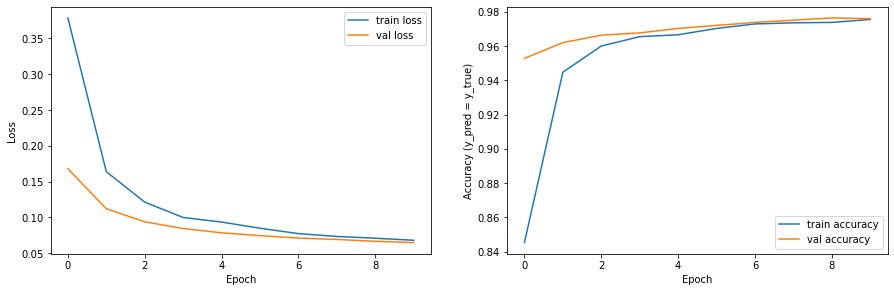

In [60]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [61]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

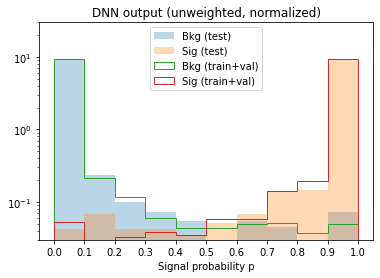

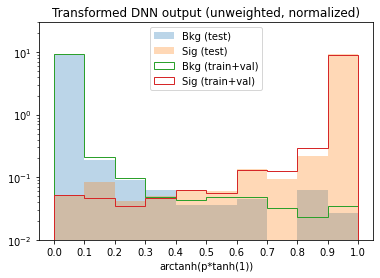

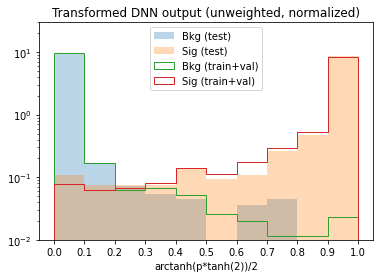

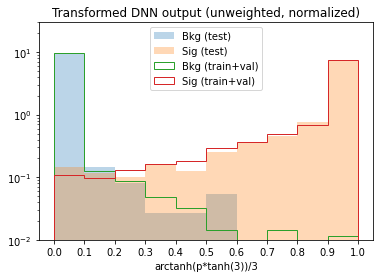

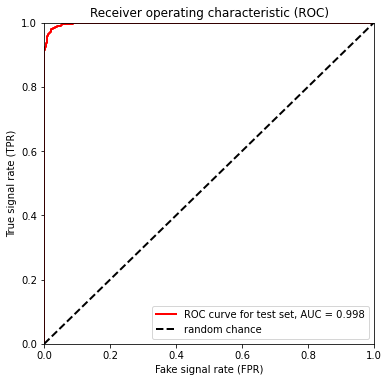

Test loss, test accuracy: [0.05798767199674686, 0.9777097702026367]


In [62]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(3e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,3e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 128)
print("Test loss, test accuracy:", results)

## Save trained model

In [63]:
joblib.dump(scaler, 'trained_models_rerunBtag/et2b_scaler.gz')
model.save('trained_models_rerunBtag/et2b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models_rerunBtag/et2b_scaler.gz')
savedmodel = keras.models.load_model('trained_models_rerunBtag/et2b_model')
savedmodel.summary()

# Write model prediction to root files (NOW USE ANOTHER NOTEBOOK TO WRITE)

## Load all root files one by one

In [64]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/et18_raw/'
outfolder18 = 'root_outputs/et18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('etau_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/et17_raw/'
outfolder17 = 'root_outputs/et17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('etau_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/et16_raw/'
outfolder16 = 'root_outputs/et16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt15.root', 'gghbbtt20.root', 'gghbbtt25.root', 'gghbbtt30.root', 'gghbbtt35.root', 'gghbbtt40.root'\
         , 'gghbbtt45.root', 'gghbbtt50.root', 'gghbbtt55.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt15.root', 'vbfbbtt20.root', 'vbfbbtt25.root', 'vbfbbtt30.root', 'vbfbbtt35.root', 'vbfbbtt40.root'\
         , 'vbfbbtt45.root', 'vbfbbtt50.root', 'vbfbbtt55.root', 'vbfbbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('etau_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mytau', mytau)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1tau', m_b1tau)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2tau', m_b2tau)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbtau', m_bbtau)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1tau', dR_b1tau)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2tau', dR_b2tau)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbtau', dR_bbtau)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_tau', mT_tau)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [65]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/et18_raw/DY.root
root_raw/et18_raw/DY1.root
root_raw/et18_raw/DY2.root
root_raw/et18_raw/DY3.root
root_raw/et18_raw/DY4.root
root_raw/et18_raw/GGHTT.root
root_raw/et18_raw/GGHWW.root
root_raw/et18_raw/GGZHLLTT.root
root_raw/et18_raw/GGZHNNTT.root
root_raw/et18_raw/GGZHQQTT.root
root_raw/et18_raw/GGZHWW.root
root_raw/et18_raw/ST_tW_antitop.root
root_raw/et18_raw/ST_tW_top.root
root_raw/et18_raw/ST_t_antitop.root
root_raw/et18_raw/ST_t_top.root
root_raw/et18_raw/TTTo2L2Nu.root
root_raw/et18_raw/TTToHadronic.root
root_raw/et18_raw/TTToSemiLeptonic.root
root_raw/et18_raw/VBFHTT.root
root_raw/et18_raw/VBFHWW.root
root_raw/et18_raw/VV2L2Nu.root
root_raw/et18_raw/WZ2L2Q.root
root_raw/et18_raw/WZ3LNu.root
root_raw/et18_raw/WminusHTT.root
root_raw/et18_raw/WminusHWW.root
root_raw/et18_raw/WplusHTT.root
root_raw/et18_raw/WplusHWW.root
root_raw/et18_raw/ZHTT.root
root_raw/et18_raw/ZHWW.root
root_raw/et18_raw/ZZ2L2Q.root
root_raw/et18_raw/ZZ4L.root
root_raw/et18_raw/data_obs.root
root_raw

In [67]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/et17_raw/DY.root
root_raw/et17_raw/DY1.root
root_raw/et17_raw/DY2.root
root_raw/et17_raw/DY3.root
root_raw/et17_raw/DY4.root
root_raw/et17_raw/GGHTT.root
root_raw/et17_raw/GGHWW.root
root_raw/et17_raw/GGZHLLTT.root
root_raw/et17_raw/GGZHNNTT.root
root_raw/et17_raw/GGZHQQTT.root
root_raw/et17_raw/GGZHWW.root
root_raw/et17_raw/ST_tW_antitop.root
root_raw/et17_raw/ST_tW_top.root
root_raw/et17_raw/ST_t_antitop.root
root_raw/et17_raw/ST_t_top.root
root_raw/et17_raw/TTTo2L2Nu.root
root_raw/et17_raw/TTToHadronic.root
root_raw/et17_raw/TTToSemiLeptonic.root
root_raw/et17_raw/VBFHTT.root
root_raw/et17_raw/VBFHWW.root
root_raw/et17_raw/VV2L2Nu.root
root_raw/et17_raw/WZ2L2Q.root
root_raw/et17_raw/WZ3L1Nu.root
root_raw/et17_raw/WminusHTT.root
root_raw/et17_raw/WminusHWW.root
root_raw/et17_raw/WplusHTT.root
root_raw/et17_raw/WplusHWW.root
root_raw/et17_raw/ZHTT.root
root_raw/et17_raw/ZHWW.root
root_raw/et17_raw/ZZ2L2Q.root
root_raw/et17_raw/ZZ4L.root
root_raw/et17_raw/data_obs.root
root_ra

In [69]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/et16_raw/DY.root
root_raw/et16_raw/DY1.root
root_raw/et16_raw/DY2.root
root_raw/et16_raw/DY3.root
root_raw/et16_raw/DY4.root
root_raw/et16_raw/GGHTT.root
root_raw/et16_raw/GGHWW.root
root_raw/et16_raw/GGZHLLTT.root
root_raw/et16_raw/GGZHNNTT.root
root_raw/et16_raw/GGZHQQTT.root
root_raw/et16_raw/GGZHWW.root
root_raw/et16_raw/ST_tW_antitop.root
root_raw/et16_raw/ST_tW_top.root
root_raw/et16_raw/ST_t_antitop.root
root_raw/et16_raw/ST_t_top.root
root_raw/et16_raw/TT.root
root_raw/et16_raw/VBFHTT.root
root_raw/et16_raw/VBFHWW.root
root_raw/et16_raw/VV2L2Nu.root
root_raw/et16_raw/WZ2L2Q.root
root_raw/et16_raw/WZ3L1Nu.root
root_raw/et16_raw/WminusHTT.root
root_raw/et16_raw/WminusHWW.root
root_raw/et16_raw/WplusHTT.root
root_raw/et16_raw/WplusHWW.root
root_raw/et16_raw/ZHTT.root
root_raw/et16_raw/ZHWW.root
root_raw/et16_raw/ZZ2L2Q.root
root_raw/et16_raw/ZZ4L.root
root_raw/et16_raw/data_obs.root
root_raw/et16_raw/embedded.root
root_raw/et16_raw/ggH_bbtt15.root
root_raw/et16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [66]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/et18_outputs/DY.root
root_outputs/et18_outputs/DY1.root
root_outputs/et18_outputs/DY2.root
root_outputs/et18_outputs/DY3.root
root_outputs/et18_outputs/DY4.root
root_outputs/et18_outputs/GGHTT.root
root_outputs/et18_outputs/GGHWW.root
root_outputs/et18_outputs/GGZHLLTT.root
root_outputs/et18_outputs/GGZHNNTT.root
root_outputs/et18_outputs/GGZHQQTT.root
root_outputs/et18_outputs/GGZHWW.root
root_outputs/et18_outputs/ST_tW_antitop.root
root_outputs/et18_outputs/ST_tW_top.root
root_outputs/et18_outputs/ST_t_antitop.root
root_outputs/et18_outputs/ST_t_top.root
root_outputs/et18_outputs/TTTo2L2Nu.root
root_outputs/et18_outputs/TTToHadronic.root
root_outputs/et18_outputs/TTToSemiLeptonic.root
root_outputs/et18_outputs/VBFHTT.root
root_outputs/et18_outputs/VBFHWW.root
root_outputs/et18_outputs/VV2L2Nu.root
root_outputs/et18_outputs/WZ2L2Q.root
root_outputs/et18_outputs/WZ3LNu.root
root_outputs/et18_outputs/WminusHTT.root
root_outputs/et18_outputs/WminusHWW.root
root_outputs/et18_

In [68]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/et17_outputs/DY.root
root_outputs/et17_outputs/DY1.root
root_outputs/et17_outputs/DY2.root
root_outputs/et17_outputs/DY3.root
root_outputs/et17_outputs/DY4.root
root_outputs/et17_outputs/GGHTT.root
root_outputs/et17_outputs/GGHWW.root
root_outputs/et17_outputs/GGZHLLTT.root
root_outputs/et17_outputs/GGZHNNTT.root
root_outputs/et17_outputs/GGZHQQTT.root
root_outputs/et17_outputs/GGZHWW.root
root_outputs/et17_outputs/ST_tW_antitop.root
root_outputs/et17_outputs/ST_tW_top.root
root_outputs/et17_outputs/ST_t_antitop.root
root_outputs/et17_outputs/ST_t_top.root
root_outputs/et17_outputs/TTTo2L2Nu.root
root_outputs/et17_outputs/TTToHadronic.root
root_outputs/et17_outputs/TTToSemiLeptonic.root
root_outputs/et17_outputs/VBFHTT.root
root_outputs/et17_outputs/VBFHWW.root
root_outputs/et17_outputs/VV2L2Nu.root
root_outputs/et17_outputs/WZ2L2Q.root
root_outputs/et17_outputs/WZ3L1Nu.root
root_outputs/et17_outputs/WminusHTT.root
root_outputs/et17_outputs/WminusHWW.root
root_outputs/et17

In [70]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'etau_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/et16_outputs/DY.root
root_outputs/et16_outputs/DY1.root
root_outputs/et16_outputs/DY2.root
root_outputs/et16_outputs/DY3.root
root_outputs/et16_outputs/DY4.root
root_outputs/et16_outputs/GGHTT.root
root_outputs/et16_outputs/GGHWW.root
root_outputs/et16_outputs/GGZHLLTT.root
root_outputs/et16_outputs/GGZHNNTT.root
root_outputs/et16_outputs/GGZHQQTT.root
root_outputs/et16_outputs/GGZHWW.root
root_outputs/et16_outputs/ST_tW_antitop.root
root_outputs/et16_outputs/ST_tW_top.root
root_outputs/et16_outputs/ST_t_antitop.root
root_outputs/et16_outputs/ST_t_top.root
root_outputs/et16_outputs/TT.root
root_outputs/et16_outputs/VBFHTT.root
root_outputs/et16_outputs/VBFHWW.root
root_outputs/et16_outputs/VV2L2Nu.root
root_outputs/et16_outputs/WZ2L2Q.root
root_outputs/et16_outputs/WZ3L1Nu.root
root_outputs/et16_outputs/WminusHTT.root
root_outputs/et16_outputs/WminusHWW.root
root_outputs/et16_outputs/WplusHTT.root
root_outputs/et16_outputs/WplusHWW.root
root_outputs/et16_outputs/ZHTT.root
